In [1]:
# example of defining a u-net encoder-decoder generator model
import os
import random
from random import randint
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use("grayscale")
%matplotlib inline
#%matplotlib notebook
import time

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage import color

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import mean_absolute_error
import keras.backend as K

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

from keras.applications.vgg19 import VGG19
from keras.models import Model

from functions import *

Using TensorFlow backend.


In [2]:
def vgg_loss_inner(y_true, y_pred):
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(256,256,3))
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
    model.trainable = False
    
    return K.mean(K.square(model(y_true) - model(y_pred)))

def vgg_obj(vgg_fact=1):
    def vgg_loss(y_true, y_pred):
        return K.abs(vgg_fact * vgg_loss_inner(y_true, y_pred) + (1-vgg_fact) * mean_absolute_error(y_true, y_pred))
    return vgg_loss

def ssim_tf(ssim_fact=1):
    def ssim_loss(y_true, y_pred):
        return K.abs(ssim_fact * (1-tf.image.ssim_multiscale(y_true, y_pred, 1)) + (1-ssim_fact) * mean_absolute_error(y_true, y_pred))
    return ssim_loss

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape, ssim_fact=0.5, loss_weights=[1,100]):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # ssim loss
    ssimTF = ssim_tf(ssim_fact=0.5)
    vggloss = vgg_obj(vgg_fact=0.5);
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', ssimTF], optimizer=opt, loss_weights=loss_weights)
    return model

In [5]:
# train pix2pix models
def train(d_model, g_model, gan_model, train_crops, n_steps, n_batch, weight_name, dir_name=None):
    if dir_name is None:
        dir_name = weight_name
    # number of iter to save state
    save_num = 200
    # size of descriminator return - 16x16
    n_patch=16
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    # init tmp vars
    g_loss_min = 100;
    d1 = []; d2 = []; g1 = []; g2 = []; g3 = [];
    ds1 = 0; ds2 = 0; gs1 = 0; gs2 = 0; gs3 = 0;
    # manually enumerate epochs
    for i in range(n_steps):
        start_time = time.time()
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(train_crops, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_total, g_cross, g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # save tmp learning losses
        ds1 += d_loss1; ds2 += d_loss2; gs1 += g_total; gs2 += g_cross; gs3 += g_loss;
        print('%d, d_real[%.3f] d_fake[%.3f] g_total[%.3f] g_cross[%.3f] g_loss[%.3f] %.3f[sec]' % (i, d_loss1, d_loss2, g_total, g_cross, g_loss, time.time()-start_time))
        # save best params
        if i % 10 == 0:
            d1.append(ds1/10);d2.append(ds2/10);g1.append(gs1/10);g2.append(gs2/10);g3.append(gs3/10);
            ds1 = 0; ds2 = 0; gs1 = 0; gs2 = 0; gs3 = 0;
            if g_loss < g_loss_min:
                g_model.save_weights(dir_name+'/g_model_best_loss_' + weight_name + '.h5')
                g_loss_min = g_loss
                print('best loss model saved!')
        # save elaps params        
        if i % save_num == 0:
            g_model.save_weights(dir_name+'/g_model_' + weight_name + '.h5')
            d_model.save_weights(dir_name+'/d_model_' + weight_name + '.h5')
            print('model saved...')
    
    g_model.save_weights(dir_name+'/g_model_' + weight_name + '.h5')
    d_model.save_weights(dir_name+'/d_model_' + weight_name + '.h5')
    return d1, d2, g1, g2, g3

In [6]:
def scedual_trainings():
    # define image shape
    t_image_shape = (256,256,1);c_image_shape = (256,256,3)
    # define the models
    batch_size = 8
    data_gen_args = dict(horizontal_flip=True)
    image_datagen = ImageDataGenerator(**data_gen_args)        
    yimage_generator = image_datagen.flow(y_train, seed=2019, batch_size=batch_size, shuffle=True)
    Ximage_generator = image_datagen.flow(X_train, seed=2019, batch_size=batch_size, shuffle=True)
    train_generator = zip(Ximage_generator, yimage_generator)
    train_crops = crop_generator(train_generator, 256, rand_crop=True)
    dir_name = 'schedualer_20.11'
    # 1
#     weight_name = 'L1_(1,100)w_50e3iter_8b'
#     d_model = define_discriminator(t_image_shape, c_image_shape)
#     g_model = define_generator(t_image_shape)
#     gan_model = define_gan(g_model, d_model, t_image_shape, ssim_fact=0, loss_weights=[1,100])
#     loss1 = train(d_model, g_model, gan_model, train_crops, 50000, batch_size, weight_name=weight_name, dir_name=dir_name)
#     save(loss1, dir_name+'/loss__'+weight_name)
    # 2
    K.clear_session()
    weight_name = 'L1_(1,300)w_30e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    gan_model = define_gan(g_model, d_model, t_image_shape, ssim_fact=0, loss_weights=[1,300])
    loss2 = train(d_model, g_model, gan_model, train_crops, 30000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss2, dir_name+'/loss__'+weight_name)
    K.clear_session()
    # 3
    weight_name = 'L1_(1,600)w_30e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    #weight_name_saved = 'L1_(1,1000)w_60e3iter_8b'
    #g_model.load_weights(dir_name+'/g_model_' + weight_name_saved + '.h5')
    #d_model.load_weights(dir_name+'/d_model_' + weight_name_saved + '.h5')   
    gan_model = define_gan(g_model, d_model, t_image_shape, ssim_fact=0, loss_weights=[1,600])
    loss3 = train(d_model, g_model, gan_model, train_crops, 30000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss3, dir_name+'/loss__'+weight_name)
    K.clear_session()
    # 3
    weight_name = 'L1_(1,800)w_30e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    gan_model = define_gan(g_model, d_model, t_image_shape, ssim_fact=0, loss_weights=[1,800])
    loss4 = train(d_model, g_model, gan_model, train_crops, 30000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss4, dir_name+'/loss__'+weight_name)
    K.clear_session()
    # 4
    weight_name = 'L1_(1,1200)w_30e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    gan_model = define_gan(g_model, d_model, t_image_shape, ssim_fact=0, loss_weights=[1,1200])
    loss5 = train(d_model, g_model, gan_model, train_crops, 30000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss5, dir_name+'/loss__'+weight_name)
    K.clear_session()
    # 5
    weight_name = 'L1_(1,1400)w_30e3iter_8b'
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    gan_model = define_gan(g_model, d_model, t_image_shape, ssim_fact=0, loss_weights=[1,1400])
    loss6 = train(d_model, g_model, gan_model, train_crops, 30000, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss6, dir_name+'/loss__'+weight_name)
    K.clear_session()

In [7]:
im_width = 640; im_height = 512
border = 5
# path_train = '../../../data/FLIR/training/Calib_cut/'
# path_train = '/home/nvs/Documents/DB/FLIR/Calib/Sample2/'
path_train = '/home/nadav.shalev/Desktop/drorna/Calib/'
X,Y = get_data(path_train, im_height, im_width)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=166/1190,random_state=2019)

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [19]:
weight_name = 'vgg_batch8'
dir_name = 'sunday_24.11'
# define image shape
t_image_shape = (256,256,1);c_image_shape = (256,256,3)
# define the models
d_model = define_discriminator(t_image_shape, c_image_shape)
g_model = define_generator(t_image_shape)
# g_model.load_weights(weight_name+'/g_model_' + weight_name + '.h5')
# d_model.load_weights(weight_name+'/d_model_' + weight_name + '.h5')

# define the composite model
gan_model = define_gan(g_model, d_model, t_image_shape)

# summarize the model
# gan_model.summary()
# plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)
batch_size = 8
data_gen_args = dict(horizontal_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)        
yimage_generator = image_datagen.flow(y_train, seed=2019, batch_size=batch_size, shuffle=True)
Ximage_generator = image_datagen.flow(X_train, seed=2019, batch_size=batch_size, shuffle=True)
train_generator = zip(Ximage_generator, yimage_generator)
train_crops = crop_generator(train_generator, 256, rand_crop=False)

80142336/80134624 [==============================] - 8s 0us/step


In [20]:
s = train(d_model, g_model, gan_model, train_crops, 100, batch_size, weight_name=weight_name, dir_name=dir_name)
save(s, dir_name+'loss__'+weight_name)

/opt/anaconda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0, d_real[0.338] d_fake[1.100] g_total[5.540] g_cross[1.752] g_loss[0.038] 16.332[sec]
best loss model saved!
model saved...
1, d_real[0.354] d_fake[1.077] g_total[4.664] g_cross[0.951] g_loss[0.037] 0.692[sec]
2, d_real[0.498] d_fake[0.982] g_total[3.532] g_cross[0.787] g_loss[0.027] 0.498[sec]
3, d_real[0.242] d_fake[0.568] g_total[4.797] g_cross[1.101] g_loss[0.037] 0.502[sec]
4, d_real[0.244] d_fake[0.434] g_total[4.310] g_cross[1.160] g_loss[0.032] 0.510[sec]
5, d_real[0.321] d_fake[0.376] g_total[4.652] g_cross[1.350] g_loss[0.033] 0.508[sec]
6, d_real[0.179] d_fake[0.328] g_total[4.235] g_cross[1.489] g_loss[0.027] 0.508[sec]
7, d_real[0.134] d_fake[0.292] g_total[4.914] g_cross[1.740] g_loss[0.032] 0.515[sec]
8, d_real[0.088] d_fake[0.212] g_total[4.816] g_cross[1.966] g_loss[0.029] 0.500[sec]
9, d_real[0.107] d_fake[0.261] g_total[4.587] g_cross[2.008] g_loss[0.026] 0.504[sec]
10, d_real[0.094] d_fake[0.179] g_total[4.685] g_cross[2.093] g_loss[0.026] 0.500[sec]
best loss mode

93, d_real[0.363] d_fake[0.261] g_total[3.658] g_cross[1.846] g_loss[0.018] 0.492[sec]
94, d_real[0.318] d_fake[0.227] g_total[3.684] g_cross[1.800] g_loss[0.019] 0.505[sec]
95, d_real[0.379] d_fake[0.370] g_total[3.974] g_cross[1.719] g_loss[0.023] 0.528[sec]
96, d_real[0.244] d_fake[0.308] g_total[4.060] g_cross[1.885] g_loss[0.022] 0.525[sec]
97, d_real[0.211] d_fake[0.230] g_total[4.173] g_cross[2.093] g_loss[0.021] 0.524[sec]
98, d_real[0.376] d_fake[0.219] g_total[3.871] g_cross[1.777] g_loss[0.021] 0.506[sec]
99, d_real[0.279] d_fake[0.434] g_total[3.838] g_cross[1.906] g_loss[0.019] 0.504[sec]


NameError: name 'pickle' is not defined

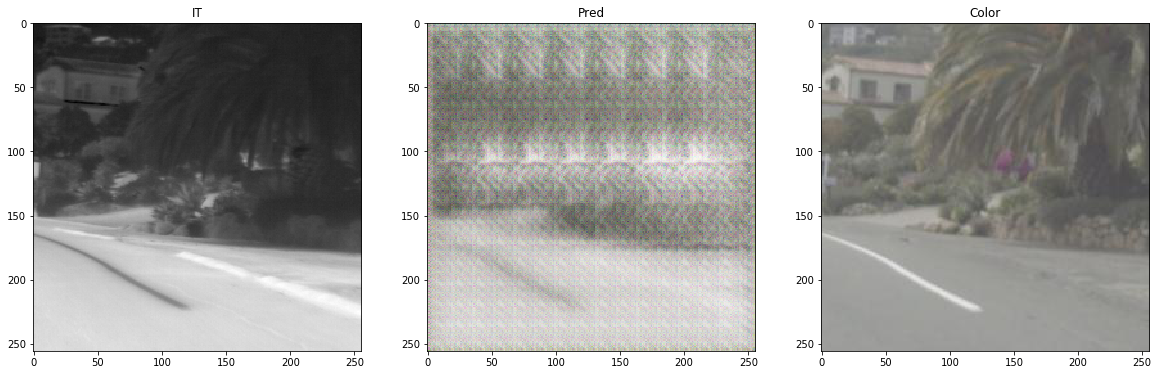

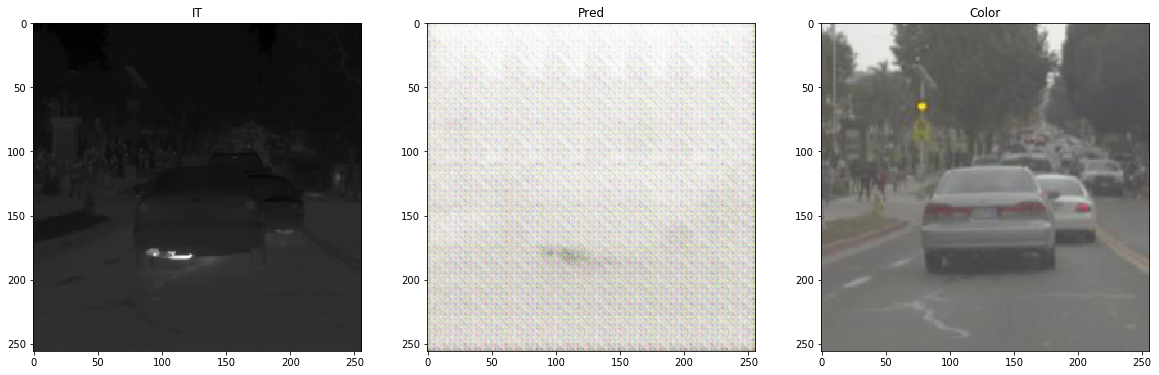

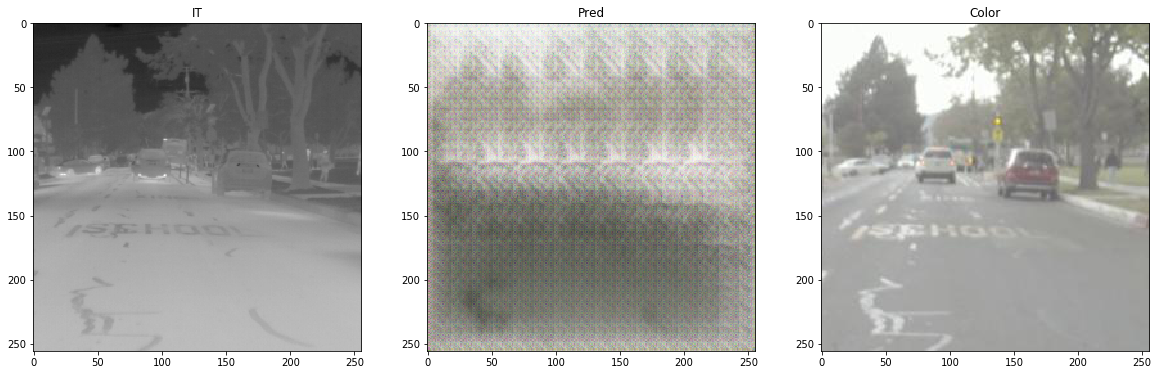

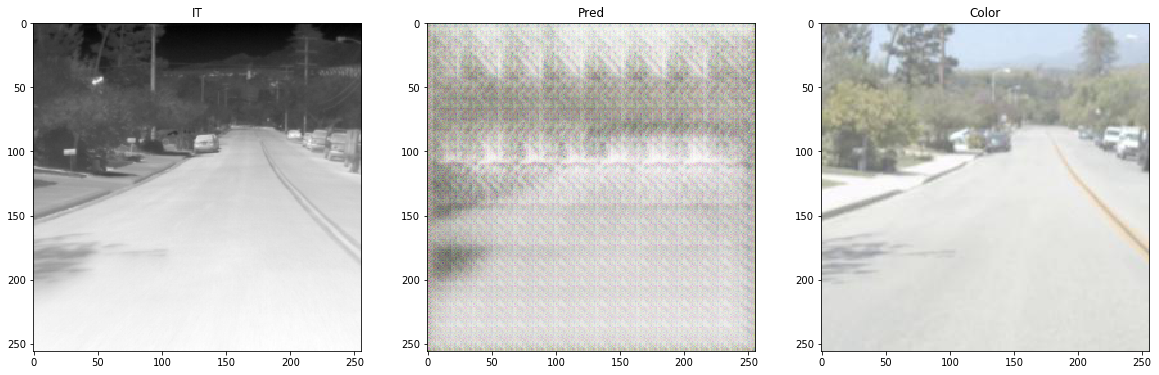

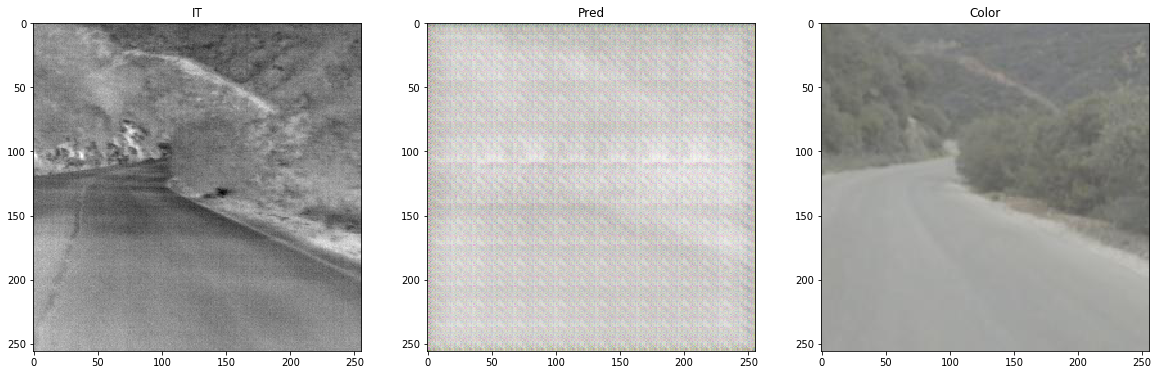

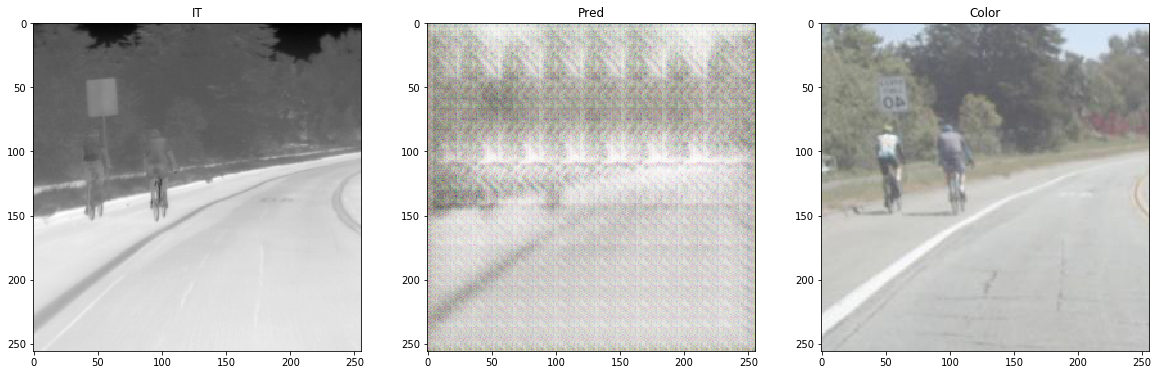

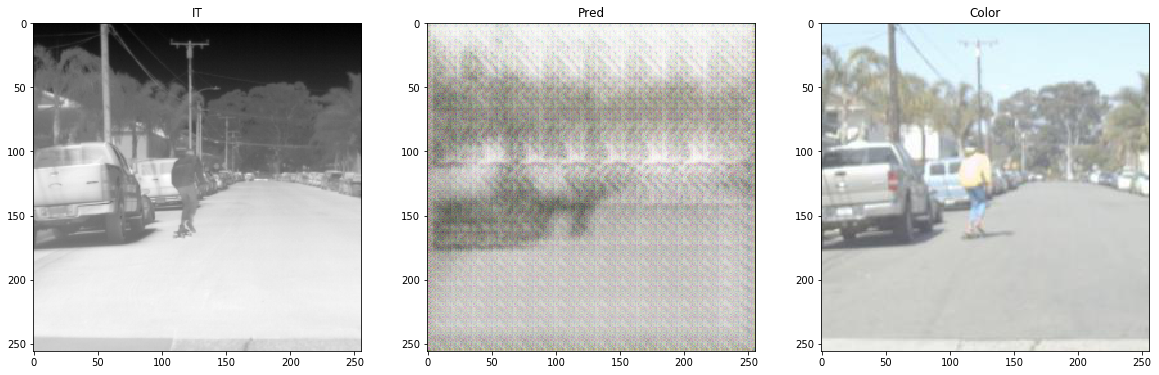

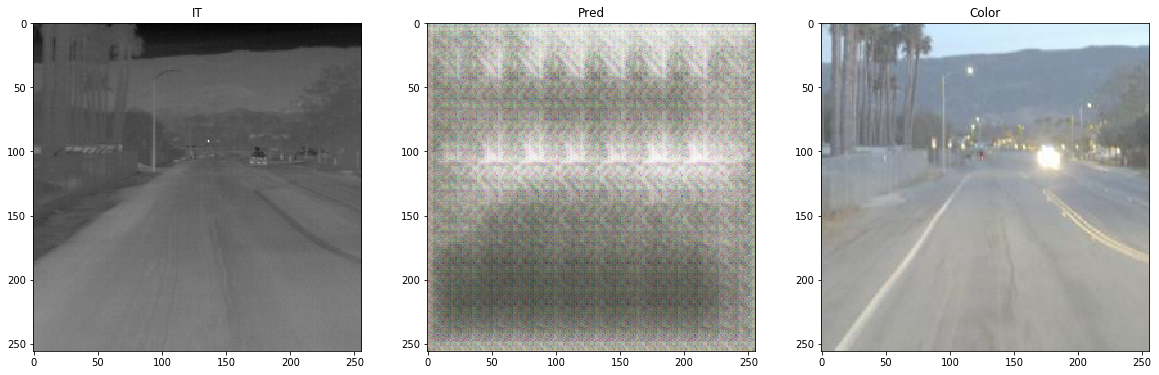

In [21]:
xi = plot_sample(train_crops, g_model)

In [30]:
#g_model.load_weights(weight_name+'/g_model_best_cross_' + weight_name + '.h5')
yimage_generator = image_datagen.flow(y_test, seed=2019, batch_size=8, shuffle=True)
Ximage_generator = image_datagen.flow(X_test, seed=2019, batch_size=8, shuffle=True)

train_generator = zip(Ximage_generator, yimage_generator)
train_crops = crop_generator(train_generator, 256, rand_crop=False)

In [185]:
x2, y2 = next(train_crops)
xi2 = K.constant(x2)
yi2= K.constant(y2)
Xr = K.constant(g_model.predict(x2))
# ssimTF = ssim_tf(ssim_fact=0.5)
# ls = ssimTF(Xr,yi2)
#ls = vgg_loss_bach(Xr, yi2,c_image_shape)
Y_pred = np.expand_dims(Xr, axis=0)
#res = np.sum(np.sum(K.eval(ls), axis=-1), axis=-1)
print(res)

ValueError: setting an array element with a sequence.

In [ ]:
gan_model = define_gan(g_model, d_model, t_image_shape)
g_total, g_cross, g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
X_realA.shape

In [23]:
n_patch = 16;n_batch = 2
[X_realA, X_realB], y_real = generate_real_samples(train_crops, n_batch, n_patch)
# generate a batch of fake samples
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
# update discriminator for real samples
d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# update discriminator for generated samples
d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
# update the generator
g_total, g_cross, g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])

ValueError: Input arrays should have the same number of samples as target arrays. Found 8 input samples and 2 target samples.

In [ ]:
scedual_trainings()

0, d_real[0.634] d_fake[0.698] g_total[201.348] g_cross[2.354] g_loss[0.663] 6.933[sec]
best loss model saved!
model saved...
1, d_real[0.533] d_fake[0.592] g_total[208.906] g_cross[2.278] g_loss[0.689] 0.350[sec]
2, d_real[0.987] d_fake[0.654] g_total[182.488] g_cross[1.708] g_loss[0.603] 0.345[sec]
3, d_real[0.528] d_fake[0.442] g_total[182.457] g_cross[1.439] g_loss[0.603] 0.344[sec]
4, d_real[0.578] d_fake[0.458] g_total[179.234] g_cross[1.288] g_loss[0.593] 0.349[sec]
5, d_real[0.232] d_fake[0.420] g_total[162.508] g_cross[1.352] g_loss[0.537] 0.346[sec]
6, d_real[0.229] d_fake[0.332] g_total[155.733] g_cross[1.459] g_loss[0.514] 0.347[sec]
7, d_real[0.227] d_fake[0.257] g_total[152.034] g_cross[1.494] g_loss[0.502] 0.352[sec]
8, d_real[0.172] d_fake[0.242] g_total[131.737] g_cross[1.669] g_loss[0.434] 0.345[sec]
9, d_real[0.169] d_fake[0.179] g_total[127.486] g_cross[1.705] g_loss[0.419] 0.349[sec]
10, d_real[0.165] d_fake[0.128] g_total[134.503] g_cross[2.024] g_loss[0.442] 0.34

92, d_real[0.063] d_fake[0.214] g_total[51.462] g_cross[2.756] g_loss[0.162] 0.359[sec]
93, d_real[0.250] d_fake[0.174] g_total[35.437] g_cross[2.471] g_loss[0.110] 0.354[sec]
94, d_real[0.325] d_fake[0.302] g_total[43.716] g_cross[2.717] g_loss[0.137] 0.355[sec]
95, d_real[0.217] d_fake[0.053] g_total[37.054] g_cross[2.672] g_loss[0.115] 0.350[sec]
96, d_real[0.036] d_fake[0.045] g_total[43.465] g_cross[2.974] g_loss[0.135] 0.352[sec]
97, d_real[0.020] d_fake[0.086] g_total[41.624] g_cross[3.009] g_loss[0.129] 0.348[sec]
98, d_real[0.144] d_fake[0.130] g_total[32.821] g_cross[3.011] g_loss[0.099] 0.344[sec]
99, d_real[0.043] d_fake[0.099] g_total[46.262] g_cross[3.109] g_loss[0.144] 0.345[sec]
100, d_real[0.032] d_fake[0.019] g_total[40.315] g_cross[3.708] g_loss[0.122] 0.355[sec]
101, d_real[0.071] d_fake[0.067] g_total[44.553] g_cross[3.645] g_loss[0.136] 0.354[sec]
102, d_real[0.066] d_fake[0.059] g_total[35.602] g_cross[3.532] g_loss[0.107] 0.349[sec]
103, d_real[0.118] d_fake[0.0

184, d_real[0.505] d_fake[0.188] g_total[33.599] g_cross[2.003] g_loss[0.105] 0.348[sec]
185, d_real[0.281] d_fake[0.219] g_total[30.372] g_cross[2.242] g_loss[0.094] 0.337[sec]
186, d_real[0.119] d_fake[0.089] g_total[42.806] g_cross[2.466] g_loss[0.134] 0.343[sec]
187, d_real[0.119] d_fake[0.176] g_total[46.702] g_cross[2.459] g_loss[0.147] 0.345[sec]
188, d_real[0.163] d_fake[0.059] g_total[41.679] g_cross[2.464] g_loss[0.131] 0.353[sec]
189, d_real[0.059] d_fake[0.074] g_total[44.248] g_cross[2.651] g_loss[0.139] 0.335[sec]
190, d_real[0.105] d_fake[0.075] g_total[31.423] g_cross[2.598] g_loss[0.096] 0.343[sec]
best loss model saved!
191, d_real[0.028] d_fake[0.075] g_total[43.592] g_cross[3.054] g_loss[0.135] 0.352[sec]
192, d_real[0.043] d_fake[0.038] g_total[42.562] g_cross[3.191] g_loss[0.131] 0.335[sec]
193, d_real[0.077] d_fake[0.088] g_total[40.798] g_cross[3.084] g_loss[0.126] 0.340[sec]
194, d_real[0.264] d_fake[0.927] g_total[39.268] g_cross[3.233] g_loss[0.120] 0.338[sec

276, d_real[0.121] d_fake[0.076] g_total[33.622] g_cross[2.374] g_loss[0.104] 0.343[sec]
277, d_real[0.020] d_fake[0.076] g_total[43.247] g_cross[2.759] g_loss[0.135] 0.342[sec]
278, d_real[0.009] d_fake[0.042] g_total[48.851] g_cross[3.116] g_loss[0.152] 0.344[sec]
279, d_real[0.018] d_fake[0.036] g_total[45.944] g_cross[3.181] g_loss[0.143] 0.343[sec]
280, d_real[0.016] d_fake[0.057] g_total[43.787] g_cross[3.115] g_loss[0.136] 0.342[sec]
281, d_real[0.326] d_fake[0.841] g_total[30.347] g_cross[3.351] g_loss[0.090] 0.341[sec]
282, d_real[0.225] d_fake[0.066] g_total[45.964] g_cross[3.025] g_loss[0.143] 0.349[sec]
283, d_real[0.062] d_fake[0.079] g_total[49.225] g_cross[2.854] g_loss[0.155] 0.354[sec]
284, d_real[0.223] d_fake[0.223] g_total[33.397] g_cross[2.589] g_loss[0.103] 0.349[sec]
285, d_real[0.080] d_fake[0.034] g_total[41.261] g_cross[3.014] g_loss[0.127] 0.351[sec]
286, d_real[0.079] d_fake[0.059] g_total[37.054] g_cross[2.572] g_loss[0.115] 0.349[sec]
287, d_real[0.010] d_

369, d_real[0.441] d_fake[0.292] g_total[39.066] g_cross[1.777] g_loss[0.124] 0.335[sec]
370, d_real[0.156] d_fake[0.099] g_total[37.256] g_cross[2.415] g_loss[0.116] 0.347[sec]
371, d_real[0.185] d_fake[0.214] g_total[45.604] g_cross[2.679] g_loss[0.143] 0.344[sec]
372, d_real[0.130] d_fake[0.028] g_total[36.061] g_cross[3.074] g_loss[0.110] 0.343[sec]
373, d_real[0.039] d_fake[0.042] g_total[36.537] g_cross[2.883] g_loss[0.112] 0.352[sec]
374, d_real[0.026] d_fake[0.079] g_total[52.829] g_cross[2.755] g_loss[0.167] 0.351[sec]
375, d_real[0.064] d_fake[0.098] g_total[40.455] g_cross[2.758] g_loss[0.126] 0.347[sec]
376, d_real[0.374] d_fake[0.329] g_total[32.248] g_cross[2.800] g_loss[0.098] 0.347[sec]
377, d_real[0.084] d_fake[0.048] g_total[33.905] g_cross[3.022] g_loss[0.103] 0.350[sec]
378, d_real[0.068] d_fake[0.056] g_total[40.985] g_cross[2.825] g_loss[0.127] 0.351[sec]
379, d_real[0.344] d_fake[0.498] g_total[28.846] g_cross[3.187] g_loss[0.086] 0.349[sec]
380, d_real[0.237] d_

461, d_real[0.013] d_fake[0.020] g_total[38.039] g_cross[3.925] g_loss[0.114] 0.344[sec]
462, d_real[0.031] d_fake[0.005] g_total[28.648] g_cross[4.888] g_loss[0.079] 0.346[sec]
463, d_real[0.006] d_fake[0.004] g_total[40.025] g_cross[5.024] g_loss[0.117] 0.357[sec]
464, d_real[0.016] d_fake[0.006] g_total[35.898] g_cross[4.646] g_loss[0.104] 0.349[sec]
465, d_real[0.003] d_fake[0.009] g_total[38.628] g_cross[4.269] g_loss[0.115] 0.347[sec]
466, d_real[0.002] d_fake[0.013] g_total[45.779] g_cross[4.027] g_loss[0.139] 0.345[sec]
467, d_real[0.005] d_fake[0.009] g_total[37.744] g_cross[4.287] g_loss[0.112] 0.349[sec]
468, d_real[0.003] d_fake[0.009] g_total[40.977] g_cross[4.266] g_loss[0.122] 0.340[sec]
469, d_real[0.015] d_fake[0.006] g_total[47.460] g_cross[4.544] g_loss[0.143] 0.344[sec]
470, d_real[0.003] d_fake[0.010] g_total[41.614] g_cross[4.143] g_loss[0.125] 0.341[sec]
471, d_real[0.011] d_fake[0.079] g_total[36.058] g_cross[4.013] g_loss[0.107] 0.340[sec]
472, d_real[0.076] d_

553, d_real[0.070] d_fake[0.164] g_total[32.220] g_cross[2.899] g_loss[0.098] 0.344[sec]
554, d_real[0.301] d_fake[0.223] g_total[36.778] g_cross[2.391] g_loss[0.115] 0.349[sec]
555, d_real[0.246] d_fake[0.141] g_total[33.963] g_cross[2.105] g_loss[0.106] 0.346[sec]
556, d_real[0.026] d_fake[0.066] g_total[37.803] g_cross[2.946] g_loss[0.116] 0.343[sec]
557, d_real[0.091] d_fake[0.052] g_total[35.633] g_cross[2.688] g_loss[0.110] 0.339[sec]
558, d_real[0.144] d_fake[0.255] g_total[33.792] g_cross[3.265] g_loss[0.102] 0.354[sec]
559, d_real[0.101] d_fake[0.037] g_total[40.614] g_cross[3.071] g_loss[0.125] 0.349[sec]
560, d_real[0.155] d_fake[0.116] g_total[33.938] g_cross[2.770] g_loss[0.104] 0.353[sec]
561, d_real[0.013] d_fake[0.019] g_total[41.786] g_cross[3.759] g_loss[0.127] 0.355[sec]
562, d_real[0.015] d_fake[0.029] g_total[41.597] g_cross[3.269] g_loss[0.128] 0.351[sec]
563, d_real[0.015] d_fake[0.028] g_total[42.178] g_cross[3.358] g_loss[0.129] 0.353[sec]
564, d_real[0.028] d_

645, d_real[0.047] d_fake[0.020] g_total[36.889] g_cross[3.440] g_loss[0.111] 0.348[sec]
646, d_real[0.022] d_fake[0.098] g_total[33.272] g_cross[3.617] g_loss[0.099] 0.352[sec]
647, d_real[0.003] d_fake[0.053] g_total[43.690] g_cross[3.788] g_loss[0.133] 0.351[sec]
648, d_real[0.061] d_fake[0.011] g_total[34.356] g_cross[4.074] g_loss[0.101] 0.354[sec]
649, d_real[0.016] d_fake[0.013] g_total[34.015] g_cross[3.864] g_loss[0.101] 0.364[sec]
650, d_real[0.007] d_fake[0.033] g_total[41.966] g_cross[3.615] g_loss[0.128] 0.352[sec]
651, d_real[0.014] d_fake[0.007] g_total[49.881] g_cross[4.443] g_loss[0.151] 0.340[sec]
652, d_real[0.032] d_fake[0.010] g_total[34.313] g_cross[4.069] g_loss[0.101] 0.345[sec]
653, d_real[0.037] d_fake[0.081] g_total[31.754] g_cross[4.184] g_loss[0.092] 0.340[sec]
654, d_real[0.009] d_fake[0.009] g_total[41.152] g_cross[4.308] g_loss[0.123] 0.345[sec]
655, d_real[0.004] d_fake[0.012] g_total[37.410] g_cross[4.174] g_loss[0.111] 0.352[sec]
656, d_real[0.006] d_

738, d_real[0.110] d_fake[0.147] g_total[44.960] g_cross[2.662] g_loss[0.141] 0.346[sec]
739, d_real[0.190] d_fake[0.066] g_total[39.623] g_cross[2.821] g_loss[0.123] 0.353[sec]
740, d_real[0.006] d_fake[0.096] g_total[36.745] g_cross[3.278] g_loss[0.112] 0.352[sec]
741, d_real[0.013] d_fake[0.028] g_total[39.343] g_cross[3.716] g_loss[0.119] 0.351[sec]
742, d_real[0.029] d_fake[0.056] g_total[41.818] g_cross[3.321] g_loss[0.128] 0.349[sec]
743, d_real[0.020] d_fake[0.005] g_total[48.157] g_cross[4.987] g_loss[0.144] 0.341[sec]
744, d_real[0.073] d_fake[0.008] g_total[33.910] g_cross[4.177] g_loss[0.099] 0.344[sec]
745, d_real[0.003] d_fake[0.068] g_total[43.320] g_cross[3.727] g_loss[0.132] 0.336[sec]
746, d_real[0.002] d_fake[0.029] g_total[50.963] g_cross[4.140] g_loss[0.156] 0.347[sec]
747, d_real[0.108] d_fake[0.010] g_total[33.661] g_cross[4.134] g_loss[0.098] 0.345[sec]
748, d_real[0.003] d_fake[0.386] g_total[37.386] g_cross[5.516] g_loss[0.106] 0.352[sec]
749, d_real[1.719] d_

830, d_real[0.054] d_fake[0.055] g_total[40.934] g_cross[3.115] g_loss[0.126] 0.348[sec]
831, d_real[0.113] d_fake[0.121] g_total[30.744] g_cross[2.700] g_loss[0.093] 0.350[sec]
832, d_real[0.024] d_fake[0.082] g_total[33.395] g_cross[2.883] g_loss[0.102] 0.347[sec]
833, d_real[0.248] d_fake[0.072] g_total[36.480] g_cross[2.323] g_loss[0.114] 0.342[sec]
834, d_real[0.014] d_fake[0.101] g_total[30.616] g_cross[3.018] g_loss[0.092] 0.345[sec]
835, d_real[0.169] d_fake[0.559] g_total[40.779] g_cross[4.070] g_loss[0.122] 0.339[sec]
836, d_real[0.199] d_fake[0.015] g_total[36.288] g_cross[3.602] g_loss[0.109] 0.344[sec]
837, d_real[0.185] d_fake[0.794] g_total[42.467] g_cross[3.951] g_loss[0.128] 0.345[sec]
838, d_real[1.110] d_fake[0.414] g_total[49.726] g_cross[2.590] g_loss[0.157] 0.354[sec]
839, d_real[0.228] d_fake[0.163] g_total[38.536] g_cross[2.719] g_loss[0.119] 0.351[sec]
840, d_real[0.131] d_fake[0.221] g_total[38.609] g_cross[2.836] g_loss[0.119] 0.349[sec]
841, d_real[0.179] d_

923, d_real[0.074] d_fake[0.040] g_total[37.608] g_cross[3.315] g_loss[0.114] 0.347[sec]
924, d_real[0.005] d_fake[0.077] g_total[39.352] g_cross[3.592] g_loss[0.119] 0.343[sec]
925, d_real[0.056] d_fake[0.170] g_total[37.776] g_cross[4.008] g_loss[0.113] 0.345[sec]
926, d_real[0.452] d_fake[0.130] g_total[34.218] g_cross[3.117] g_loss[0.104] 0.343[sec]
927, d_real[0.008] d_fake[0.359] g_total[41.229] g_cross[5.426] g_loss[0.119] 0.349[sec]
928, d_real[1.444] d_fake[0.073] g_total[38.749] g_cross[2.223] g_loss[0.122] 0.351[sec]
929, d_real[0.162] d_fake[0.119] g_total[34.641] g_cross[2.664] g_loss[0.107] 0.348[sec]
930, d_real[0.061] d_fake[0.596] g_total[40.682] g_cross[4.189] g_loss[0.122] 0.347[sec]
931, d_real[0.275] d_fake[0.016] g_total[37.779] g_cross[3.911] g_loss[0.113] 0.347[sec]
932, d_real[0.381] d_fake[0.215] g_total[38.715] g_cross[2.439] g_loss[0.121] 0.346[sec]
933, d_real[0.129] d_fake[0.141] g_total[31.337] g_cross[3.020] g_loss[0.094] 0.349[sec]
934, d_real[0.014] d_

1015, d_real[0.128] d_fake[0.024] g_total[32.932] g_cross[3.414] g_loss[0.098] 0.351[sec]
1016, d_real[0.420] d_fake[0.024] g_total[38.586] g_cross[2.310] g_loss[0.121] 0.349[sec]
1017, d_real[0.004] d_fake[0.992] g_total[37.838] g_cross[4.167] g_loss[0.112] 0.353[sec]
1018, d_real[0.021] d_fake[0.016] g_total[41.982] g_cross[4.430] g_loss[0.125] 0.351[sec]
1019, d_real[0.993] d_fake[0.157] g_total[30.935] g_cross[2.157] g_loss[0.096] 0.347[sec]
1020, d_real[0.007] d_fake[0.382] g_total[42.374] g_cross[3.689] g_loss[0.129] 0.347[sec]
1021, d_real[0.221] d_fake[0.023] g_total[39.931] g_cross[3.491] g_loss[0.121] 0.342[sec]
1022, d_real[0.052] d_fake[0.048] g_total[39.112] g_cross[2.833] g_loss[0.121] 0.338[sec]
1023, d_real[0.073] d_fake[0.256] g_total[35.440] g_cross[3.439] g_loss[0.107] 0.342[sec]
1024, d_real[0.091] d_fake[0.031] g_total[41.533] g_cross[3.400] g_loss[0.127] 0.345[sec]
1025, d_real[0.271] d_fake[0.324] g_total[39.055] g_cross[3.236] g_loss[0.119] 0.347[sec]
1026, d_re

1107, d_real[0.012] d_fake[0.259] g_total[42.034] g_cross[3.123] g_loss[0.130] 0.345[sec]
1108, d_real[0.426] d_fake[0.388] g_total[35.967] g_cross[3.063] g_loss[0.110] 0.344[sec]
1109, d_real[0.058] d_fake[0.038] g_total[35.244] g_cross[3.322] g_loss[0.106] 0.345[sec]
1110, d_real[0.149] d_fake[0.084] g_total[43.589] g_cross[2.570] g_loss[0.137] 0.339[sec]
1111, d_real[0.316] d_fake[0.224] g_total[32.958] g_cross[2.350] g_loss[0.102] 0.344[sec]
1112, d_real[0.060] d_fake[0.094] g_total[37.426] g_cross[3.086] g_loss[0.114] 0.335[sec]
1113, d_real[0.162] d_fake[0.457] g_total[34.552] g_cross[3.887] g_loss[0.102] 0.338[sec]
1114, d_real[0.061] d_fake[0.007] g_total[38.454] g_cross[4.723] g_loss[0.112] 0.352[sec]
1115, d_real[0.132] d_fake[0.020] g_total[35.188] g_cross[3.442] g_loss[0.106] 0.350[sec]
1116, d_real[0.091] d_fake[0.120] g_total[33.228] g_cross[2.508] g_loss[0.102] 0.346[sec]
1117, d_real[0.002] d_fake[0.178] g_total[45.872] g_cross[2.884] g_loss[0.143] 0.348[sec]
1118, d_re

1198, d_real[0.069] d_fake[0.036] g_total[43.169] g_cross[2.940] g_loss[0.134] 0.351[sec]
1199, d_real[0.088] d_fake[0.156] g_total[40.248] g_cross[3.076] g_loss[0.124] 0.347[sec]
1200, d_real[0.113] d_fake[0.184] g_total[32.433] g_cross[3.562] g_loss[0.096] 0.352[sec]
model saved...
1201, d_real[0.038] d_fake[0.039] g_total[33.164] g_cross[3.684] g_loss[0.098] 0.357[sec]
1202, d_real[0.101] d_fake[0.065] g_total[43.781] g_cross[2.681] g_loss[0.137] 0.340[sec]
1203, d_real[0.033] d_fake[0.061] g_total[43.553] g_cross[3.125] g_loss[0.135] 0.338[sec]
1204, d_real[0.034] d_fake[0.135] g_total[44.431] g_cross[4.150] g_loss[0.134] 0.374[sec]
1205, d_real[0.136] d_fake[0.060] g_total[46.884] g_cross[3.030] g_loss[0.146] 0.340[sec]
1206, d_real[0.014] d_fake[0.201] g_total[42.554] g_cross[3.908] g_loss[0.129] 0.339[sec]
1207, d_real[0.597] d_fake[0.121] g_total[40.641] g_cross[2.414] g_loss[0.127] 0.349[sec]
1208, d_real[0.569] d_fake[1.971] g_total[40.193] g_cross[2.147] g_loss[0.127] 0.357[

1289, d_real[0.066] d_fake[0.159] g_total[44.275] g_cross[3.243] g_loss[0.137] 0.349[sec]
1290, d_real[0.126] d_fake[0.042] g_total[36.139] g_cross[2.852] g_loss[0.111] 0.348[sec]
1291, d_real[0.071] d_fake[0.026] g_total[37.139] g_cross[3.229] g_loss[0.113] 0.342[sec]
1292, d_real[0.104] d_fake[0.068] g_total[43.634] g_cross[2.713] g_loss[0.136] 0.345[sec]
1293, d_real[0.002] d_fake[0.069] g_total[41.281] g_cross[2.867] g_loss[0.128] 0.346[sec]
1294, d_real[0.013] d_fake[0.062] g_total[38.710] g_cross[2.879] g_loss[0.119] 0.349[sec]
1295, d_real[0.023] d_fake[0.028] g_total[37.946] g_cross[3.439] g_loss[0.115] 0.352[sec]
1296, d_real[0.077] d_fake[0.049] g_total[38.362] g_cross[2.866] g_loss[0.118] 0.349[sec]
1297, d_real[0.036] d_fake[0.133] g_total[32.255] g_cross[2.920] g_loss[0.098] 0.341[sec]
1298, d_real[0.199] d_fake[0.054] g_total[39.023] g_cross[2.662] g_loss[0.121] 0.343[sec]
1299, d_real[0.267] d_fake[0.258] g_total[30.627] g_cross[2.887] g_loss[0.092] 0.344[sec]
1300, d_re

1380, d_real[0.025] d_fake[0.211] g_total[40.227] g_cross[3.295] g_loss[0.123] 0.341[sec]
1381, d_real[0.263] d_fake[0.134] g_total[37.764] g_cross[2.681] g_loss[0.117] 0.347[sec]
1382, d_real[1.119] d_fake[0.297] g_total[40.268] g_cross[2.006] g_loss[0.128] 0.360[sec]
1383, d_real[0.017] d_fake[0.365] g_total[40.527] g_cross[3.191] g_loss[0.124] 0.364[sec]
1384, d_real[0.365] d_fake[0.633] g_total[27.076] g_cross[3.060] g_loss[0.080] 0.348[sec]
1385, d_real[0.101] d_fake[0.110] g_total[47.528] g_cross[3.071] g_loss[0.148] 0.352[sec]
1386, d_real[0.595] d_fake[0.149] g_total[32.282] g_cross[2.046] g_loss[0.101] 0.346[sec]
1387, d_real[0.140] d_fake[0.355] g_total[39.939] g_cross[2.813] g_loss[0.124] 0.346[sec]
1388, d_real[0.381] d_fake[0.127] g_total[32.580] g_cross[2.270] g_loss[0.101] 0.345[sec]
1389, d_real[0.092] d_fake[0.230] g_total[40.519] g_cross[2.761] g_loss[0.126] 0.343[sec]
1390, d_real[0.758] d_fake[0.341] g_total[39.074] g_cross[2.378] g_loss[0.122] 0.340[sec]
1391, d_re

1471, d_real[0.356] d_fake[0.115] g_total[37.051] g_cross[1.715] g_loss[0.118] 0.351[sec]
1472, d_real[0.020] d_fake[0.168] g_total[37.446] g_cross[2.557] g_loss[0.116] 0.345[sec]
1473, d_real[0.013] d_fake[0.124] g_total[29.781] g_cross[2.832] g_loss[0.090] 0.347[sec]
1474, d_real[0.086] d_fake[0.073] g_total[49.722] g_cross[2.697] g_loss[0.157] 0.353[sec]
1475, d_real[0.034] d_fake[0.121] g_total[37.338] g_cross[2.642] g_loss[0.116] 0.346[sec]
1476, d_real[0.360] d_fake[0.109] g_total[32.809] g_cross[2.114] g_loss[0.102] 0.345[sec]
1477, d_real[0.138] d_fake[0.394] g_total[31.976] g_cross[3.073] g_loss[0.096] 0.344[sec]
1478, d_real[0.187] d_fake[0.162] g_total[32.857] g_cross[2.485] g_loss[0.101] 0.347[sec]
1479, d_real[0.249] d_fake[0.046] g_total[35.568] g_cross[2.530] g_loss[0.110] 0.354[sec]
1480, d_real[0.045] d_fake[0.149] g_total[28.450] g_cross[2.902] g_loss[0.085] 0.350[sec]
1481, d_real[0.041] d_fake[0.494] g_total[33.137] g_cross[3.346] g_loss[0.099] 0.354[sec]
1482, d_re

1563, d_real[0.019] d_fake[0.058] g_total[33.467] g_cross[3.027] g_loss[0.101] 0.345[sec]
1564, d_real[0.055] d_fake[0.315] g_total[32.723] g_cross[4.253] g_loss[0.095] 0.348[sec]
1565, d_real[0.294] d_fake[0.179] g_total[36.828] g_cross[3.320] g_loss[0.112] 0.358[sec]
1566, d_real[0.209] d_fake[0.150] g_total[37.314] g_cross[2.979] g_loss[0.114] 0.351[sec]
1567, d_real[1.109] d_fake[0.599] g_total[47.465] g_cross[3.539] g_loss[0.146] 0.348[sec]
1568, d_real[0.104] d_fake[0.038] g_total[49.031] g_cross[3.341] g_loss[0.152] 0.350[sec]
1569, d_real[0.051] d_fake[0.132] g_total[37.047] g_cross[2.842] g_loss[0.114] 0.351[sec]
1570, d_real[1.359] d_fake[0.122] g_total[34.138] g_cross[1.489] g_loss[0.109] 0.347[sec]
1571, d_real[0.001] d_fake[1.090] g_total[34.395] g_cross[4.271] g_loss[0.100] 0.345[sec]
1572, d_real[0.832] d_fake[0.076] g_total[30.832] g_cross[2.094] g_loss[0.096] 0.343[sec]
1573, d_real[0.028] d_fake[0.331] g_total[42.141] g_cross[2.556] g_loss[0.132] 0.342[sec]
1574, d_re

1654, d_real[0.038] d_fake[0.065] g_total[39.600] g_cross[3.226] g_loss[0.121] 0.352[sec]
1655, d_real[0.014] d_fake[0.050] g_total[36.203] g_cross[3.187] g_loss[0.110] 0.348[sec]
1656, d_real[0.440] d_fake[0.428] g_total[38.399] g_cross[3.120] g_loss[0.118] 0.352[sec]
1657, d_real[0.753] d_fake[0.364] g_total[31.110] g_cross[2.336] g_loss[0.096] 0.350[sec]
1658, d_real[0.021] d_fake[0.399] g_total[34.254] g_cross[2.859] g_loss[0.105] 0.354[sec]
1659, d_real[0.198] d_fake[0.015] g_total[36.289] g_cross[3.970] g_loss[0.108] 0.344[sec]
1660, d_real[0.210] d_fake[0.021] g_total[41.881] g_cross[3.277] g_loss[0.129] 0.337[sec]
1661, d_real[0.006] d_fake[0.112] g_total[39.188] g_cross[2.501] g_loss[0.122] 0.343[sec]
1662, d_real[0.138] d_fake[0.077] g_total[38.388] g_cross[2.598] g_loss[0.119] 0.339[sec]
1663, d_real[0.059] d_fake[0.094] g_total[29.211] g_cross[2.711] g_loss[0.088] 0.336[sec]
1664, d_real[0.024] d_fake[0.111] g_total[37.188] g_cross[2.856] g_loss[0.114] 0.349[sec]
1665, d_re

1746, d_real[0.133] d_fake[0.022] g_total[36.878] g_cross[3.603] g_loss[0.111] 0.345[sec]
1747, d_real[0.263] d_fake[0.756] g_total[35.993] g_cross[3.354] g_loss[0.109] 0.347[sec]
1748, d_real[0.168] d_fake[0.025] g_total[40.946] g_cross[4.108] g_loss[0.123] 0.342[sec]
1749, d_real[0.256] d_fake[0.220] g_total[30.080] g_cross[2.072] g_loss[0.093] 0.350[sec]
1750, d_real[0.202] d_fake[0.298] g_total[25.858] g_cross[2.503] g_loss[0.078] 0.342[sec]
1751, d_real[0.018] d_fake[0.128] g_total[38.711] g_cross[2.840] g_loss[0.120] 0.346[sec]
1752, d_real[0.186] d_fake[0.212] g_total[43.082] g_cross[2.676] g_loss[0.135] 0.345[sec]
1753, d_real[0.421] d_fake[0.171] g_total[28.743] g_cross[1.871] g_loss[0.090] 0.347[sec]
1754, d_real[0.167] d_fake[0.506] g_total[37.930] g_cross[3.043] g_loss[0.116] 0.350[sec]
1755, d_real[0.554] d_fake[0.152] g_total[32.825] g_cross[2.363] g_loss[0.102] 0.342[sec]
1756, d_real[0.057] d_fake[0.546] g_total[40.422] g_cross[3.322] g_loss[0.124] 0.351[sec]
1757, d_re

1837, d_real[0.296] d_fake[0.145] g_total[31.088] g_cross[2.293] g_loss[0.096] 0.346[sec]
1838, d_real[0.036] d_fake[0.121] g_total[37.706] g_cross[2.544] g_loss[0.117] 0.346[sec]
1839, d_real[0.031] d_fake[0.123] g_total[34.366] g_cross[2.944] g_loss[0.105] 0.344[sec]
1840, d_real[0.117] d_fake[0.067] g_total[33.605] g_cross[2.948] g_loss[0.102] 0.344[sec]
1841, d_real[0.170] d_fake[0.449] g_total[41.725] g_cross[3.559] g_loss[0.127] 0.345[sec]
1842, d_real[0.419] d_fake[0.132] g_total[31.487] g_cross[2.307] g_loss[0.097] 0.343[sec]
1843, d_real[0.226] d_fake[0.153] g_total[34.683] g_cross[2.394] g_loss[0.108] 0.346[sec]
1844, d_real[0.138] d_fake[0.109] g_total[35.724] g_cross[2.770] g_loss[0.110] 0.344[sec]
1845, d_real[0.009] d_fake[0.388] g_total[33.987] g_cross[3.820] g_loss[0.101] 0.350[sec]
1846, d_real[0.728] d_fake[0.028] g_total[33.048] g_cross[2.509] g_loss[0.102] 0.343[sec]
1847, d_real[0.005] d_fake[0.056] g_total[35.661] g_cross[3.258] g_loss[0.108] 0.343[sec]
1848, d_re

1929, d_real[0.040] d_fake[0.166] g_total[37.099] g_cross[2.708] g_loss[0.115] 0.344[sec]
1930, d_real[0.017] d_fake[0.087] g_total[40.182] g_cross[3.027] g_loss[0.124] 0.349[sec]
1931, d_real[0.303] d_fake[0.245] g_total[30.602] g_cross[3.156] g_loss[0.091] 0.342[sec]
1932, d_real[0.098] d_fake[0.178] g_total[33.046] g_cross[3.377] g_loss[0.099] 0.346[sec]
1933, d_real[0.253] d_fake[0.277] g_total[26.921] g_cross[3.190] g_loss[0.079] 0.346[sec]
1934, d_real[0.439] d_fake[0.196] g_total[28.701] g_cross[2.141] g_loss[0.089] 0.351[sec]
1935, d_real[0.041] d_fake[0.077] g_total[43.090] g_cross[3.152] g_loss[0.133] 0.347[sec]
1936, d_real[0.037] d_fake[0.224] g_total[33.193] g_cross[3.013] g_loss[0.101] 0.348[sec]
1937, d_real[0.299] d_fake[0.068] g_total[33.617] g_cross[2.426] g_loss[0.104] 0.347[sec]
1938, d_real[0.006] d_fake[0.318] g_total[45.119] g_cross[3.327] g_loss[0.139] 0.349[sec]
1939, d_real[0.226] d_fake[0.058] g_total[30.678] g_cross[2.799] g_loss[0.093] 0.348[sec]
1940, d_re

2020, d_real[0.642] d_fake[0.085] g_total[34.592] g_cross[1.885] g_loss[0.109] 0.349[sec]
2021, d_real[0.014] d_fake[0.216] g_total[31.558] g_cross[3.660] g_loss[0.093] 0.343[sec]
2022, d_real[0.140] d_fake[0.119] g_total[32.816] g_cross[3.039] g_loss[0.099] 0.344[sec]
2023, d_real[0.085] d_fake[0.127] g_total[30.009] g_cross[3.005] g_loss[0.090] 0.340[sec]
2024, d_real[0.034] d_fake[0.128] g_total[36.704] g_cross[2.918] g_loss[0.113] 0.340[sec]
2025, d_real[0.092] d_fake[0.019] g_total[39.042] g_cross[3.790] g_loss[0.118] 0.349[sec]
2026, d_real[0.298] d_fake[0.590] g_total[31.618] g_cross[3.646] g_loss[0.093] 0.355[sec]
2027, d_real[0.073] d_fake[0.095] g_total[41.815] g_cross[3.424] g_loss[0.128] 0.353[sec]
2028, d_real[0.060] d_fake[0.089] g_total[37.235] g_cross[3.150] g_loss[0.114] 0.350[sec]
2029, d_real[0.132] d_fake[0.081] g_total[40.732] g_cross[3.064] g_loss[0.126] 0.347[sec]
2030, d_real[0.385] d_fake[0.696] g_total[33.635] g_cross[4.094] g_loss[0.098] 0.347[sec]
2031, d_re

2112, d_real[0.239] d_fake[0.149] g_total[33.479] g_cross[2.175] g_loss[0.104] 0.352[sec]
2113, d_real[0.038] d_fake[0.121] g_total[37.783] g_cross[2.941] g_loss[0.116] 0.355[sec]
2114, d_real[0.170] d_fake[0.102] g_total[34.002] g_cross[2.320] g_loss[0.106] 0.355[sec]
2115, d_real[0.019] d_fake[0.017] g_total[31.049] g_cross[3.875] g_loss[0.091] 0.351[sec]
2116, d_real[0.072] d_fake[0.092] g_total[25.878] g_cross[2.696] g_loss[0.077] 0.347[sec]
2117, d_real[0.014] d_fake[0.130] g_total[34.824] g_cross[2.596] g_loss[0.107] 0.349[sec]
2118, d_real[0.187] d_fake[0.059] g_total[34.676] g_cross[2.751] g_loss[0.106] 0.349[sec]
2119, d_real[0.017] d_fake[0.297] g_total[32.258] g_cross[4.709] g_loss[0.092] 0.347[sec]
2120, d_real[0.008] d_fake[0.006] g_total[48.896] g_cross[5.186] g_loss[0.146] 0.346[sec]
2121, d_real[1.531] d_fake[0.107] g_total[27.517] g_cross[1.823] g_loss[0.086] 0.352[sec]
2122, d_real[0.016] d_fake[0.692] g_total[39.627] g_cross[3.781] g_loss[0.119] 0.350[sec]
2123, d_re

2203, d_real[0.054] d_fake[0.168] g_total[30.400] g_cross[3.354] g_loss[0.090] 0.350[sec]
2204, d_real[0.590] d_fake[0.147] g_total[34.417] g_cross[2.828] g_loss[0.105] 0.351[sec]
2205, d_real[0.037] d_fake[0.256] g_total[34.285] g_cross[3.893] g_loss[0.101] 0.338[sec]
2206, d_real[0.035] d_fake[0.019] g_total[35.232] g_cross[4.257] g_loss[0.103] 0.340[sec]
2207, d_real[0.260] d_fake[0.181] g_total[35.676] g_cross[2.488] g_loss[0.111] 0.335[sec]
2208, d_real[0.334] d_fake[0.450] g_total[23.892] g_cross[2.460] g_loss[0.071] 0.347[sec]
2209, d_real[0.036] d_fake[0.138] g_total[29.567] g_cross[2.944] g_loss[0.089] 0.349[sec]
2210, d_real[0.065] d_fake[0.117] g_total[31.963] g_cross[2.730] g_loss[0.097] 0.345[sec]
2211, d_real[0.087] d_fake[0.042] g_total[32.636] g_cross[2.971] g_loss[0.099] 0.344[sec]
2212, d_real[0.126] d_fake[0.125] g_total[33.034] g_cross[2.434] g_loss[0.102] 0.353[sec]
2213, d_real[0.219] d_fake[0.246] g_total[31.424] g_cross[2.718] g_loss[0.096] 0.341[sec]
2214, d_re

2295, d_real[0.130] d_fake[0.093] g_total[32.709] g_cross[2.591] g_loss[0.100] 0.347[sec]
2296, d_real[0.047] d_fake[0.007] g_total[37.182] g_cross[4.589] g_loss[0.109] 0.343[sec]
2297, d_real[0.110] d_fake[0.020] g_total[33.905] g_cross[3.412] g_loss[0.102] 0.344[sec]
2298, d_real[0.005] d_fake[0.179] g_total[34.874] g_cross[3.126] g_loss[0.106] 0.347[sec]
2299, d_real[0.045] d_fake[0.082] g_total[38.669] g_cross[2.927] g_loss[0.119] 0.344[sec]
2300, d_real[0.029] d_fake[0.009] g_total[32.784] g_cross[4.364] g_loss[0.095] 0.358[sec]
2301, d_real[0.089] d_fake[0.013] g_total[28.284] g_cross[3.942] g_loss[0.081] 0.354[sec]
2302, d_real[0.008] d_fake[0.060] g_total[33.964] g_cross[2.907] g_loss[0.104] 0.354[sec]
2303, d_real[0.055] d_fake[0.151] g_total[31.823] g_cross[2.925] g_loss[0.096] 0.345[sec]
2304, d_real[0.049] d_fake[0.008] g_total[35.328] g_cross[4.636] g_loss[0.102] 0.357[sec]
2305, d_real[0.185] d_fake[0.043] g_total[34.461] g_cross[2.738] g_loss[0.106] 0.349[sec]
2306, d_re

2387, d_real[0.007] d_fake[0.069] g_total[36.845] g_cross[3.670] g_loss[0.111] 0.350[sec]
2388, d_real[0.047] d_fake[0.008] g_total[35.488] g_cross[4.439] g_loss[0.103] 0.348[sec]
2389, d_real[0.265] d_fake[0.019] g_total[34.982] g_cross[3.644] g_loss[0.104] 0.349[sec]
2390, d_real[0.083] d_fake[0.451] g_total[30.167] g_cross[3.525] g_loss[0.089] 0.350[sec]
2391, d_real[0.156] d_fake[0.019] g_total[41.262] g_cross[3.545] g_loss[0.126] 0.344[sec]
2392, d_real[0.013] d_fake[0.218] g_total[35.104] g_cross[3.856] g_loss[0.104] 0.349[sec]
2393, d_real[0.100] d_fake[0.092] g_total[33.082] g_cross[2.916] g_loss[0.101] 0.352[sec]
2394, d_real[0.094] d_fake[0.014] g_total[41.240] g_cross[3.913] g_loss[0.124] 0.351[sec]
2395, d_real[0.131] d_fake[0.035] g_total[34.114] g_cross[3.007] g_loss[0.104] 0.347[sec]
2396, d_real[0.015] d_fake[0.240] g_total[39.639] g_cross[3.412] g_loss[0.121] 0.346[sec]
2397, d_real[0.201] d_fake[0.656] g_total[35.062] g_cross[3.577] g_loss[0.105] 0.349[sec]
2398, d_re

2478, d_real[0.013] d_fake[0.047] g_total[41.136] g_cross[3.454] g_loss[0.126] 0.349[sec]
2479, d_real[0.120] d_fake[0.357] g_total[37.388] g_cross[3.796] g_loss[0.112] 0.349[sec]
2480, d_real[0.175] d_fake[0.134] g_total[40.236] g_cross[3.099] g_loss[0.124] 0.349[sec]
2481, d_real[0.044] d_fake[0.067] g_total[32.321] g_cross[3.118] g_loss[0.097] 0.350[sec]
2482, d_real[0.210] d_fake[0.255] g_total[37.017] g_cross[3.428] g_loss[0.112] 0.345[sec]
2483, d_real[0.215] d_fake[0.119] g_total[33.304] g_cross[3.045] g_loss[0.101] 0.348[sec]
2484, d_real[0.107] d_fake[0.048] g_total[29.266] g_cross[2.943] g_loss[0.088] 0.347[sec]
2485, d_real[0.014] d_fake[0.537] g_total[33.983] g_cross[5.138] g_loss[0.096] 0.348[sec]
2486, d_real[1.565] d_fake[0.266] g_total[33.996] g_cross[2.404] g_loss[0.105] 0.344[sec]
2487, d_real[1.068] d_fake[0.173] g_total[32.442] g_cross[2.473] g_loss[0.100] 0.340[sec]
2488, d_real[0.036] d_fake[0.122] g_total[30.594] g_cross[2.932] g_loss[0.092] 0.336[sec]
2489, d_re

2570, d_real[0.281] d_fake[0.144] g_total[36.038] g_cross[2.314] g_loss[0.112] 0.354[sec]
2571, d_real[0.011] d_fake[0.208] g_total[36.141] g_cross[2.912] g_loss[0.111] 0.346[sec]
2572, d_real[0.426] d_fake[0.192] g_total[30.333] g_cross[2.389] g_loss[0.093] 0.342[sec]
2573, d_real[0.050] d_fake[0.062] g_total[45.048] g_cross[3.167] g_loss[0.140] 0.342[sec]
2574, d_real[0.053] d_fake[0.078] g_total[37.927] g_cross[3.071] g_loss[0.116] 0.342[sec]
2575, d_real[0.287] d_fake[0.114] g_total[36.879] g_cross[2.306] g_loss[0.115] 0.346[sec]
2576, d_real[0.008] d_fake[0.466] g_total[38.683] g_cross[4.228] g_loss[0.115] 0.346[sec]
2577, d_real[0.807] d_fake[0.089] g_total[26.203] g_cross[2.221] g_loss[0.080] 0.342[sec]
2578, d_real[0.030] d_fake[0.175] g_total[30.522] g_cross[2.966] g_loss[0.092] 0.339[sec]
2579, d_real[0.060] d_fake[0.024] g_total[41.952] g_cross[3.524] g_loss[0.128] 0.343[sec]
2580, d_real[0.383] d_fake[0.269] g_total[31.773] g_cross[2.764] g_loss[0.097] 0.346[sec]
2581, d_re

2661, d_real[0.368] d_fake[0.085] g_total[27.203] g_cross[2.601] g_loss[0.082] 0.352[sec]
2662, d_real[0.360] d_fake[0.716] g_total[32.159] g_cross[4.384] g_loss[0.093] 0.352[sec]
2663, d_real[0.035] d_fake[0.072] g_total[39.522] g_cross[3.712] g_loss[0.119] 0.348[sec]
2664, d_real[0.440] d_fake[0.783] g_total[34.149] g_cross[3.768] g_loss[0.101] 0.354[sec]
2665, d_real[1.584] d_fake[0.510] g_total[31.287] g_cross[1.650] g_loss[0.099] 0.349[sec]
2666, d_real[0.302] d_fake[0.191] g_total[29.705] g_cross[2.584] g_loss[0.090] 0.343[sec]
2667, d_real[0.234] d_fake[0.023] g_total[33.932] g_cross[3.474] g_loss[0.102] 0.342[sec]
2668, d_real[0.372] d_fake[1.166] g_total[32.300] g_cross[3.316] g_loss[0.097] 0.339[sec]
2669, d_real[0.130] d_fake[0.121] g_total[42.499] g_cross[3.509] g_loss[0.130] 0.340[sec]
2670, d_real[0.707] d_fake[0.708] g_total[36.419] g_cross[4.285] g_loss[0.107] 0.346[sec]
2671, d_real[0.202] d_fake[0.025] g_total[32.873] g_cross[3.343] g_loss[0.098] 0.350[sec]
2672, d_re

2753, d_real[0.001] d_fake[0.103] g_total[32.536] g_cross[3.678] g_loss[0.096] 0.351[sec]
2754, d_real[0.008] d_fake[0.036] g_total[32.537] g_cross[4.146] g_loss[0.095] 0.348[sec]
2755, d_real[0.018] d_fake[0.205] g_total[32.886] g_cross[3.393] g_loss[0.098] 0.347[sec]
2756, d_real[0.032] d_fake[0.189] g_total[33.533] g_cross[3.338] g_loss[0.101] 0.343[sec]
2757, d_real[0.804] d_fake[0.283] g_total[33.647] g_cross[2.061] g_loss[0.105] 0.344[sec]
2758, d_real[0.016] d_fake[0.242] g_total[34.098] g_cross[3.255] g_loss[0.103] 0.387[sec]
2759, d_real[0.236] d_fake[0.076] g_total[28.788] g_cross[2.897] g_loss[0.086] 0.344[sec]
2760, d_real[0.009] d_fake[0.229] g_total[47.980] g_cross[3.338] g_loss[0.149] 0.341[sec]
2761, d_real[0.131] d_fake[0.060] g_total[54.448] g_cross[3.341] g_loss[0.170] 0.346[sec]
2762, d_real[0.177] d_fake[0.368] g_total[35.973] g_cross[3.261] g_loss[0.109] 0.349[sec]
2763, d_real[0.023] d_fake[0.173] g_total[33.001] g_cross[4.098] g_loss[0.096] 0.357[sec]
2764, d_re

2844, d_real[0.546] d_fake[0.584] g_total[44.079] g_cross[3.384] g_loss[0.136] 0.367[sec]
2845, d_real[0.016] d_fake[0.009] g_total[37.272] g_cross[4.942] g_loss[0.108] 0.358[sec]
2846, d_real[0.688] d_fake[0.028] g_total[35.051] g_cross[2.713] g_loss[0.108] 0.360[sec]
2847, d_real[0.102] d_fake[0.115] g_total[26.804] g_cross[2.562] g_loss[0.081] 0.353[sec]
2848, d_real[0.023] d_fake[0.306] g_total[31.116] g_cross[4.055] g_loss[0.090] 0.362[sec]
2849, d_real[0.109] d_fake[0.008] g_total[33.799] g_cross[4.517] g_loss[0.098] 0.365[sec]
2850, d_real[0.049] d_fake[0.114] g_total[27.265] g_cross[2.920] g_loss[0.081] 0.382[sec]
2851, d_real[0.341] d_fake[0.126] g_total[43.701] g_cross[2.751] g_loss[0.137] 0.375[sec]
2852, d_real[0.017] d_fake[0.381] g_total[35.938] g_cross[3.580] g_loss[0.108] 0.371[sec]
2853, d_real[0.406] d_fake[0.045] g_total[30.369] g_cross[2.838] g_loss[0.092] 0.369[sec]
2854, d_real[0.011] d_fake[0.061] g_total[30.242] g_cross[2.967] g_loss[0.091] 0.367[sec]
2855, d_re

2936, d_real[0.550] d_fake[0.218] g_total[26.718] g_cross[2.857] g_loss[0.080] 0.344[sec]
2937, d_real[0.040] d_fake[0.154] g_total[31.247] g_cross[4.313] g_loss[0.090] 0.351[sec]
2938, d_real[0.256] d_fake[0.018] g_total[27.345] g_cross[3.404] g_loss[0.080] 0.369[sec]
2939, d_real[0.004] d_fake[0.047] g_total[32.801] g_cross[3.516] g_loss[0.098] 0.351[sec]
2940, d_real[0.057] d_fake[0.131] g_total[31.529] g_cross[3.314] g_loss[0.094] 0.359[sec]
2941, d_real[0.019] d_fake[0.050] g_total[36.681] g_cross[3.653] g_loss[0.110] 0.349[sec]
2942, d_real[0.008] d_fake[0.036] g_total[34.885] g_cross[3.504] g_loss[0.105] 0.354[sec]
2943, d_real[0.015] d_fake[0.017] g_total[29.921] g_cross[4.141] g_loss[0.086] 0.351[sec]
2944, d_real[0.180] d_fake[0.109] g_total[35.140] g_cross[3.021] g_loss[0.107] 0.345[sec]
2945, d_real[0.175] d_fake[0.137] g_total[40.571] g_cross[3.241] g_loss[0.124] 0.343[sec]
2946, d_real[0.009] d_fake[0.065] g_total[38.800] g_cross[3.447] g_loss[0.118] 0.360[sec]
2947, d_re

3027, d_real[0.230] d_fake[1.039] g_total[32.971] g_cross[5.801] g_loss[0.091] 0.356[sec]
3028, d_real[1.311] d_fake[0.823] g_total[30.342] g_cross[3.566] g_loss[0.089] 0.372[sec]
3029, d_real[0.068] d_fake[0.029] g_total[37.218] g_cross[4.404] g_loss[0.109] 0.354[sec]
3030, d_real[1.486] d_fake[0.628] g_total[36.309] g_cross[4.279] g_loss[0.107] 0.344[sec]
3031, d_real[0.388] d_fake[0.219] g_total[31.288] g_cross[3.177] g_loss[0.094] 0.349[sec]
3032, d_real[0.022] d_fake[0.148] g_total[32.858] g_cross[3.171] g_loss[0.099] 0.345[sec]
3033, d_real[0.138] d_fake[0.010] g_total[33.096] g_cross[4.324] g_loss[0.096] 0.349[sec]
3034, d_real[0.048] d_fake[0.019] g_total[32.376] g_cross[3.614] g_loss[0.096] 0.371[sec]
3035, d_real[0.019] d_fake[0.159] g_total[29.183] g_cross[2.981] g_loss[0.087] 0.341[sec]
3036, d_real[0.020] d_fake[0.025] g_total[37.293] g_cross[3.723] g_loss[0.112] 0.356[sec]
3037, d_real[0.116] d_fake[0.097] g_total[34.066] g_cross[2.472] g_loss[0.105] 0.355[sec]
3038, d_re

3119, d_real[0.004] d_fake[0.193] g_total[36.576] g_cross[4.413] g_loss[0.107] 0.363[sec]
3120, d_real[0.664] d_fake[0.370] g_total[45.494] g_cross[4.687] g_loss[0.136] 0.350[sec]
3121, d_real[0.150] d_fake[0.074] g_total[38.386] g_cross[4.555] g_loss[0.113] 0.354[sec]
3122, d_real[0.013] d_fake[0.165] g_total[37.647] g_cross[4.098] g_loss[0.112] 0.343[sec]
3123, d_real[0.412] d_fake[0.045] g_total[37.585] g_cross[3.173] g_loss[0.115] 0.349[sec]
3124, d_real[0.020] d_fake[0.058] g_total[30.610] g_cross[3.771] g_loss[0.089] 0.353[sec]
3125, d_real[0.004] d_fake[0.396] g_total[48.574] g_cross[4.417] g_loss[0.147] 0.348[sec]
3126, d_real[0.010] d_fake[0.004] g_total[42.972] g_cross[6.208] g_loss[0.123] 0.350[sec]
3127, d_real[0.419] d_fake[0.190] g_total[33.499] g_cross[3.192] g_loss[0.101] 0.354[sec]
3128, d_real[0.066] d_fake[0.079] g_total[43.539] g_cross[3.351] g_loss[0.134] 0.351[sec]
3129, d_real[0.070] d_fake[0.123] g_total[36.026] g_cross[3.517] g_loss[0.108] 0.347[sec]
3130, d_re

3210, d_real[0.006] d_fake[0.144] g_total[37.189] g_cross[3.354] g_loss[0.113] 0.339[sec]
3211, d_real[0.112] d_fake[0.014] g_total[33.374] g_cross[3.871] g_loss[0.098] 0.339[sec]
3212, d_real[0.080] d_fake[0.197] g_total[37.347] g_cross[2.849] g_loss[0.115] 0.341[sec]
3213, d_real[0.215] d_fake[0.168] g_total[27.994] g_cross[2.855] g_loss[0.084] 0.341[sec]
3214, d_real[0.362] d_fake[0.416] g_total[38.486] g_cross[3.368] g_loss[0.117] 0.348[sec]
3215, d_real[0.085] d_fake[0.100] g_total[32.043] g_cross[3.300] g_loss[0.096] 0.348[sec]
3216, d_real[0.351] d_fake[0.041] g_total[34.434] g_cross[2.557] g_loss[0.106] 0.347[sec]
3217, d_real[0.012] d_fake[0.184] g_total[31.411] g_cross[3.530] g_loss[0.093] 0.347[sec]
3218, d_real[0.034] d_fake[0.068] g_total[30.719] g_cross[3.453] g_loss[0.091] 0.344[sec]
3219, d_real[0.192] d_fake[0.062] g_total[44.125] g_cross[2.835] g_loss[0.138] 0.338[sec]
3220, d_real[0.084] d_fake[0.113] g_total[48.303] g_cross[3.096] g_loss[0.151] 0.342[sec]
3221, d_re

3302, d_real[0.426] d_fake[0.084] g_total[29.114] g_cross[2.304] g_loss[0.089] 0.341[sec]
3303, d_real[0.179] d_fake[0.326] g_total[29.002] g_cross[4.182] g_loss[0.083] 0.342[sec]
3304, d_real[0.298] d_fake[0.043] g_total[30.797] g_cross[3.035] g_loss[0.093] 0.343[sec]
3305, d_real[0.107] d_fake[0.293] g_total[37.528] g_cross[3.566] g_loss[0.113] 0.349[sec]
3306, d_real[0.024] d_fake[0.140] g_total[40.971] g_cross[4.378] g_loss[0.122] 0.341[sec]
3307, d_real[0.110] d_fake[0.002] g_total[34.558] g_cross[6.170] g_loss[0.095] 0.341[sec]
3308, d_real[0.105] d_fake[0.001] g_total[35.604] g_cross[6.734] g_loss[0.096] 0.341[sec]
3309, d_real[0.112] d_fake[0.015] g_total[29.785] g_cross[3.847] g_loss[0.086] 0.338[sec]
3310, d_real[0.003] d_fake[0.035] g_total[41.785] g_cross[3.393] g_loss[0.128] 0.346[sec]
3311, d_real[0.011] d_fake[0.041] g_total[30.492] g_cross[3.429] g_loss[0.090] 0.347[sec]
3312, d_real[0.004] d_fake[0.046] g_total[30.455] g_cross[3.494] g_loss[0.090] 0.352[sec]
3313, d_re

3394, d_real[0.122] d_fake[0.158] g_total[30.954] g_cross[2.687] g_loss[0.094] 0.356[sec]
3395, d_real[0.072] d_fake[0.048] g_total[32.185] g_cross[3.216] g_loss[0.097] 0.355[sec]
3396, d_real[0.363] d_fake[0.469] g_total[28.967] g_cross[2.310] g_loss[0.089] 0.350[sec]
3397, d_real[0.120] d_fake[0.032] g_total[40.465] g_cross[3.386] g_loss[0.124] 0.354[sec]
3398, d_real[0.014] d_fake[0.021] g_total[33.360] g_cross[3.838] g_loss[0.098] 0.341[sec]
3399, d_real[0.011] d_fake[0.087] g_total[37.477] g_cross[3.260] g_loss[0.114] 0.368[sec]
3400, d_real[0.249] d_fake[0.062] g_total[28.100] g_cross[2.696] g_loss[0.085] 0.350[sec]
model saved...
3401, d_real[0.011] d_fake[0.079] g_total[32.675] g_cross[3.197] g_loss[0.098] 0.385[sec]
3402, d_real[0.080] d_fake[0.342] g_total[30.875] g_cross[3.343] g_loss[0.092] 0.340[sec]
3403, d_real[0.146] d_fake[0.025] g_total[35.251] g_cross[3.576] g_loss[0.106] 0.375[sec]
3404, d_real[0.066] d_fake[0.029] g_total[39.706] g_cross[3.193] g_loss[0.122] 0.361[

3485, d_real[0.029] d_fake[0.013] g_total[32.333] g_cross[3.656] g_loss[0.096] 0.348[sec]
3486, d_real[0.009] d_fake[0.168] g_total[35.563] g_cross[2.990] g_loss[0.109] 0.356[sec]
3487, d_real[0.114] d_fake[0.217] g_total[45.870] g_cross[3.012] g_loss[0.143] 0.344[sec]
3488, d_real[0.156] d_fake[0.234] g_total[33.068] g_cross[2.710] g_loss[0.101] 0.351[sec]
3489, d_real[0.132] d_fake[0.085] g_total[34.643] g_cross[2.891] g_loss[0.106] 0.359[sec]
3490, d_real[0.011] d_fake[0.104] g_total[32.693] g_cross[3.092] g_loss[0.099] 0.361[sec]
3491, d_real[0.149] d_fake[0.027] g_total[26.072] g_cross[3.128] g_loss[0.076] 0.339[sec]
3492, d_real[0.075] d_fake[0.016] g_total[29.303] g_cross[3.598] g_loss[0.086] 0.340[sec]
3493, d_real[0.021] d_fake[0.077] g_total[35.709] g_cross[3.254] g_loss[0.108] 0.351[sec]
3494, d_real[0.013] d_fake[0.131] g_total[33.305] g_cross[3.285] g_loss[0.100] 0.347[sec]
3495, d_real[0.086] d_fake[0.091] g_total[35.018] g_cross[3.151] g_loss[0.106] 0.338[sec]
3496, d_re

3577, d_real[0.289] d_fake[0.079] g_total[29.032] g_cross[2.956] g_loss[0.087] 0.346[sec]
3578, d_real[0.174] d_fake[0.236] g_total[28.820] g_cross[3.512] g_loss[0.084] 0.345[sec]
3579, d_real[0.108] d_fake[0.043] g_total[34.291] g_cross[3.456] g_loss[0.103] 0.357[sec]
3580, d_real[0.085] d_fake[0.181] g_total[38.947] g_cross[2.795] g_loss[0.121] 0.386[sec]
3581, d_real[0.057] d_fake[0.140] g_total[29.346] g_cross[2.991] g_loss[0.088] 0.359[sec]
3582, d_real[0.203] d_fake[0.103] g_total[27.759] g_cross[2.899] g_loss[0.083] 0.353[sec]
3583, d_real[0.160] d_fake[0.238] g_total[39.021] g_cross[3.026] g_loss[0.120] 0.360[sec]
3584, d_real[0.063] d_fake[0.036] g_total[30.762] g_cross[3.435] g_loss[0.091] 0.359[sec]
3585, d_real[0.056] d_fake[0.072] g_total[30.945] g_cross[3.116] g_loss[0.093] 0.347[sec]
3586, d_real[0.093] d_fake[0.047] g_total[29.749] g_cross[2.995] g_loss[0.089] 0.352[sec]
3587, d_real[0.035] d_fake[0.022] g_total[35.800] g_cross[3.539] g_loss[0.108] 0.374[sec]
3588, d_re

3668, d_real[0.078] d_fake[0.047] g_total[39.755] g_cross[3.074] g_loss[0.122] 0.355[sec]
3669, d_real[0.047] d_fake[0.113] g_total[32.967] g_cross[2.871] g_loss[0.100] 0.359[sec]
3670, d_real[0.137] d_fake[0.333] g_total[30.855] g_cross[3.528] g_loss[0.091] 0.374[sec]
3671, d_real[0.140] d_fake[0.026] g_total[37.393] g_cross[3.527] g_loss[0.113] 0.375[sec]
3672, d_real[0.610] d_fake[0.237] g_total[37.526] g_cross[1.990] g_loss[0.118] 0.344[sec]
3673, d_real[0.006] d_fake[0.515] g_total[37.510] g_cross[4.856] g_loss[0.109] 0.348[sec]
3674, d_real[0.507] d_fake[0.172] g_total[37.123] g_cross[2.663] g_loss[0.115] 0.355[sec]
3675, d_real[0.265] d_fake[0.037] g_total[28.946] g_cross[2.526] g_loss[0.088] 0.353[sec]
3676, d_real[0.032] d_fake[0.205] g_total[37.225] g_cross[2.826] g_loss[0.115] 0.347[sec]
3677, d_real[0.033] d_fake[0.123] g_total[36.522] g_cross[3.218] g_loss[0.111] 0.352[sec]
3678, d_real[0.397] d_fake[0.116] g_total[28.872] g_cross[2.483] g_loss[0.088] 0.356[sec]
3679, d_re

3760, d_real[0.005] d_fake[0.045] g_total[41.055] g_cross[3.372] g_loss[0.126] 0.350[sec]
3761, d_real[0.419] d_fake[0.388] g_total[34.953] g_cross[3.061] g_loss[0.106] 0.381[sec]
3762, d_real[0.277] d_fake[0.289] g_total[44.173] g_cross[3.592] g_loss[0.135] 0.363[sec]
3763, d_real[0.053] d_fake[0.150] g_total[42.860] g_cross[3.374] g_loss[0.132] 0.376[sec]
3764, d_real[0.433] d_fake[0.005] g_total[35.529] g_cross[4.122] g_loss[0.105] 0.344[sec]
3765, d_real[0.110] d_fake[0.486] g_total[45.282] g_cross[4.688] g_loss[0.135] 0.348[sec]
3766, d_real[0.263] d_fake[0.013] g_total[25.967] g_cross[3.857] g_loss[0.074] 0.384[sec]
3767, d_real[0.039] d_fake[0.118] g_total[37.206] g_cross[3.860] g_loss[0.111] 0.378[sec]
3768, d_real[0.027] d_fake[0.060] g_total[32.876] g_cross[3.927] g_loss[0.096] 0.359[sec]
3769, d_real[0.401] d_fake[0.185] g_total[33.138] g_cross[3.472] g_loss[0.099] 0.382[sec]
3770, d_real[0.008] d_fake[0.147] g_total[36.195] g_cross[5.160] g_loss[0.103] 0.364[sec]
3771, d_re

3851, d_real[0.043] d_fake[0.030] g_total[34.190] g_cross[3.494] g_loss[0.102] 0.354[sec]
3852, d_real[0.288] d_fake[0.373] g_total[31.223] g_cross[4.090] g_loss[0.090] 0.350[sec]
3853, d_real[0.136] d_fake[0.022] g_total[28.512] g_cross[3.829] g_loss[0.082] 0.350[sec]
3854, d_real[0.097] d_fake[0.054] g_total[37.184] g_cross[2.749] g_loss[0.115] 0.349[sec]
3855, d_real[0.032] d_fake[0.039] g_total[27.257] g_cross[3.110] g_loss[0.080] 0.353[sec]
3856, d_real[0.006] d_fake[0.120] g_total[39.116] g_cross[2.933] g_loss[0.121] 0.350[sec]
3857, d_real[0.094] d_fake[0.040] g_total[28.271] g_cross[3.123] g_loss[0.084] 0.357[sec]
3858, d_real[0.066] d_fake[0.141] g_total[32.753] g_cross[3.339] g_loss[0.098] 0.358[sec]
3859, d_real[0.145] d_fake[0.031] g_total[33.179] g_cross[3.168] g_loss[0.100] 0.354[sec]
3860, d_real[0.031] d_fake[0.049] g_total[35.079] g_cross[3.216] g_loss[0.106] 0.353[sec]
3861, d_real[0.024] d_fake[0.082] g_total[33.493] g_cross[3.397] g_loss[0.100] 0.354[sec]
3862, d_re

3943, d_real[0.066] d_fake[0.019] g_total[37.392] g_cross[3.617] g_loss[0.113] 0.363[sec]
3944, d_real[0.041] d_fake[0.224] g_total[31.606] g_cross[3.831] g_loss[0.093] 0.346[sec]
3945, d_real[0.151] d_fake[0.012] g_total[31.873] g_cross[4.285] g_loss[0.092] 0.358[sec]
3946, d_real[0.092] d_fake[0.415] g_total[40.027] g_cross[6.357] g_loss[0.112] 0.348[sec]
3947, d_real[0.277] d_fake[0.011] g_total[32.720] g_cross[3.635] g_loss[0.097] 0.352[sec]
3948, d_real[0.214] d_fake[0.301] g_total[32.186] g_cross[3.107] g_loss[0.097] 0.352[sec]
3949, d_real[0.002] d_fake[0.042] g_total[49.096] g_cross[4.152] g_loss[0.150] 0.355[sec]
3950, d_real[0.064] d_fake[0.056] g_total[28.801] g_cross[3.236] g_loss[0.085] 0.350[sec]
3951, d_real[0.040] d_fake[0.007] g_total[36.585] g_cross[4.607] g_loss[0.107] 0.354[sec]
3952, d_real[0.058] d_fake[0.252] g_total[37.791] g_cross[5.016] g_loss[0.109] 0.357[sec]
3953, d_real[0.587] d_fake[0.104] g_total[26.249] g_cross[2.334] g_loss[0.080] 0.345[sec]
3954, d_re

4034, d_real[0.449] d_fake[0.319] g_total[28.342] g_cross[2.925] g_loss[0.085] 0.365[sec]
4035, d_real[0.080] d_fake[0.177] g_total[28.818] g_cross[3.564] g_loss[0.084] 0.373[sec]
4036, d_real[0.336] d_fake[0.076] g_total[34.023] g_cross[2.824] g_loss[0.104] 0.360[sec]
4037, d_real[0.008] d_fake[0.347] g_total[31.162] g_cross[5.563] g_loss[0.085] 0.354[sec]
4038, d_real[0.289] d_fake[0.010] g_total[33.041] g_cross[4.200] g_loss[0.096] 0.372[sec]
4039, d_real[0.021] d_fake[0.130] g_total[31.525] g_cross[3.797] g_loss[0.092] 0.361[sec]
4040, d_real[0.137] d_fake[0.026] g_total[37.963] g_cross[3.300] g_loss[0.116] 0.357[sec]
4041, d_real[0.020] d_fake[0.042] g_total[31.534] g_cross[3.449] g_loss[0.094] 0.348[sec]
4042, d_real[0.005] d_fake[0.281] g_total[33.369] g_cross[4.089] g_loss[0.098] 0.346[sec]
4043, d_real[0.028] d_fake[0.003] g_total[40.466] g_cross[5.721] g_loss[0.116] 0.353[sec]
4044, d_real[1.450] d_fake[0.048] g_total[32.299] g_cross[1.533] g_loss[0.103] 0.341[sec]
4045, d_re

4126, d_real[0.012] d_fake[0.143] g_total[36.970] g_cross[3.389] g_loss[0.112] 0.345[sec]
4127, d_real[0.015] d_fake[0.025] g_total[32.904] g_cross[3.857] g_loss[0.097] 0.344[sec]
4128, d_real[0.029] d_fake[0.390] g_total[38.412] g_cross[5.498] g_loss[0.110] 0.352[sec]
4129, d_real[0.573] d_fake[0.011] g_total[32.000] g_cross[3.291] g_loss[0.096] 0.350[sec]
4130, d_real[0.054] d_fake[0.178] g_total[35.153] g_cross[3.197] g_loss[0.107] 0.350[sec]
4131, d_real[0.239] d_fake[0.152] g_total[27.405] g_cross[3.701] g_loss[0.079] 0.346[sec]
4132, d_real[0.285] d_fake[0.137] g_total[28.641] g_cross[3.066] g_loss[0.085] 0.344[sec]
4133, d_real[0.024] d_fake[0.278] g_total[39.246] g_cross[4.002] g_loss[0.117] 0.347[sec]
4134, d_real[0.084] d_fake[0.049] g_total[34.828] g_cross[3.715] g_loss[0.104] 0.347[sec]
4135, d_real[0.236] d_fake[0.208] g_total[36.727] g_cross[3.089] g_loss[0.112] 0.345[sec]
4136, d_real[0.231] d_fake[0.208] g_total[27.789] g_cross[2.999] g_loss[0.083] 0.359[sec]
4137, d_re

4217, d_real[0.088] d_fake[0.059] g_total[30.275] g_cross[3.477] g_loss[0.089] 0.360[sec]
4218, d_real[0.082] d_fake[0.079] g_total[35.863] g_cross[3.288] g_loss[0.109] 0.351[sec]
4219, d_real[0.031] d_fake[0.309] g_total[31.051] g_cross[4.746] g_loss[0.088] 0.384[sec]
4220, d_real[0.239] d_fake[0.007] g_total[43.677] g_cross[4.665] g_loss[0.130] 0.351[sec]
4221, d_real[0.245] d_fake[0.053] g_total[24.998] g_cross[2.698] g_loss[0.074] 0.344[sec]
4222, d_real[0.014] d_fake[0.137] g_total[31.689] g_cross[3.642] g_loss[0.093] 0.343[sec]
4223, d_real[0.052] d_fake[0.088] g_total[28.892] g_cross[3.521] g_loss[0.085] 0.343[sec]
4224, d_real[0.058] d_fake[0.044] g_total[41.591] g_cross[3.517] g_loss[0.127] 0.364[sec]
4225, d_real[0.126] d_fake[0.244] g_total[30.032] g_cross[4.160] g_loss[0.086] 0.356[sec]
4226, d_real[0.249] d_fake[0.247] g_total[40.642] g_cross[5.105] g_loss[0.118] 0.354[sec]
4227, d_real[0.858] d_fake[0.220] g_total[28.435] g_cross[2.223] g_loss[0.087] 0.350[sec]
4228, d_re

4309, d_real[0.147] d_fake[0.115] g_total[28.878] g_cross[2.785] g_loss[0.087] 0.354[sec]
4310, d_real[0.021] d_fake[0.119] g_total[35.806] g_cross[2.995] g_loss[0.109] 0.360[sec]
4311, d_real[0.376] d_fake[0.378] g_total[31.459] g_cross[4.474] g_loss[0.090] 0.357[sec]
4312, d_real[0.089] d_fake[0.041] g_total[37.731] g_cross[3.581] g_loss[0.114] 0.345[sec]
4313, d_real[0.324] d_fake[0.080] g_total[36.531] g_cross[2.396] g_loss[0.114] 0.343[sec]
4314, d_real[0.016] d_fake[0.133] g_total[31.968] g_cross[3.695] g_loss[0.094] 0.342[sec]
4315, d_real[0.022] d_fake[0.054] g_total[36.564] g_cross[3.747] g_loss[0.109] 0.351[sec]
4316, d_real[0.028] d_fake[0.071] g_total[30.170] g_cross[3.480] g_loss[0.089] 0.352[sec]
4317, d_real[0.474] d_fake[0.264] g_total[34.832] g_cross[3.701] g_loss[0.104] 0.340[sec]
4318, d_real[0.022] d_fake[0.228] g_total[33.956] g_cross[4.594] g_loss[0.098] 0.373[sec]
4319, d_real[0.046] d_fake[0.030] g_total[35.015] g_cross[4.169] g_loss[0.103] 0.352[sec]
4320, d_re

model saved...
4401, d_real[0.012] d_fake[0.049] g_total[39.194] g_cross[3.760] g_loss[0.118] 0.352[sec]
4402, d_real[0.164] d_fake[0.053] g_total[38.557] g_cross[2.917] g_loss[0.119] 0.359[sec]
4403, d_real[0.008] d_fake[0.075] g_total[41.573] g_cross[3.244] g_loss[0.128] 0.354[sec]
4404, d_real[0.138] d_fake[0.025] g_total[29.469] g_cross[3.253] g_loss[0.087] 0.345[sec]
4405, d_real[0.010] d_fake[0.164] g_total[30.631] g_cross[3.799] g_loss[0.089] 0.337[sec]
4406, d_real[0.008] d_fake[0.026] g_total[34.433] g_cross[4.043] g_loss[0.101] 0.340[sec]
4407, d_real[0.080] d_fake[0.005] g_total[35.770] g_cross[4.766] g_loss[0.103] 0.344[sec]
4408, d_real[0.047] d_fake[0.038] g_total[30.224] g_cross[3.266] g_loss[0.090] 0.342[sec]
4409, d_real[0.009] d_fake[0.048] g_total[28.901] g_cross[3.376] g_loss[0.085] 0.351[sec]
4410, d_real[0.093] d_fake[0.161] g_total[31.882] g_cross[3.732] g_loss[0.094] 0.350[sec]
4411, d_real[0.090] d_fake[0.098] g_total[29.728] g_cross[3.452] g_loss[0.088] 0.354[

4492, d_real[0.017] d_fake[0.013] g_total[45.516] g_cross[4.299] g_loss[0.137] 0.350[sec]
4493, d_real[0.056] d_fake[0.160] g_total[30.789] g_cross[3.238] g_loss[0.092] 0.352[sec]
4494, d_real[0.180] d_fake[0.090] g_total[36.635] g_cross[3.095] g_loss[0.112] 0.345[sec]
4495, d_real[0.056] d_fake[0.024] g_total[35.008] g_cross[3.483] g_loss[0.105] 0.343[sec]
4496, d_real[0.032] d_fake[0.065] g_total[31.900] g_cross[3.147] g_loss[0.096] 0.347[sec]
4497, d_real[0.020] d_fake[0.020] g_total[37.437] g_cross[3.756] g_loss[0.112] 0.353[sec]
4498, d_real[0.054] d_fake[0.086] g_total[41.514] g_cross[3.304] g_loss[0.127] 0.355[sec]
4499, d_real[0.340] d_fake[0.027] g_total[31.677] g_cross[2.830] g_loss[0.096] 0.357[sec]
4500, d_real[0.008] d_fake[0.332] g_total[42.456] g_cross[4.747] g_loss[0.126] 0.355[sec]
4501, d_real[0.009] d_fake[0.020] g_total[37.586] g_cross[6.060] g_loss[0.105] 0.349[sec]
4502, d_real[0.147] d_fake[0.031] g_total[30.503] g_cross[2.953] g_loss[0.092] 0.348[sec]
4503, d_re

4584, d_real[0.010] d_fake[0.088] g_total[40.257] g_cross[3.601] g_loss[0.122] 0.343[sec]
4585, d_real[0.010] d_fake[0.030] g_total[37.891] g_cross[3.882] g_loss[0.113] 0.366[sec]
4586, d_real[0.068] d_fake[0.014] g_total[39.964] g_cross[3.789] g_loss[0.121] 0.368[sec]
4587, d_real[0.091] d_fake[0.103] g_total[32.143] g_cross[3.566] g_loss[0.095] 0.354[sec]
4588, d_real[0.041] d_fake[0.078] g_total[31.004] g_cross[3.197] g_loss[0.093] 0.355[sec]
4589, d_real[0.706] d_fake[0.281] g_total[28.355] g_cross[3.728] g_loss[0.082] 0.351[sec]
4590, d_real[0.023] d_fake[0.249] g_total[38.063] g_cross[4.763] g_loss[0.111] 0.353[sec]
4591, d_real[0.157] d_fake[0.033] g_total[30.687] g_cross[3.383] g_loss[0.091] 0.350[sec]
4592, d_real[0.051] d_fake[0.146] g_total[33.632] g_cross[3.326] g_loss[0.101] 0.343[sec]
4593, d_real[0.053] d_fake[0.069] g_total[38.412] g_cross[3.299] g_loss[0.117] 0.343[sec]
4594, d_real[0.081] d_fake[0.044] g_total[29.467] g_cross[3.303] g_loss[0.087] 0.348[sec]
4595, d_re

In [47]:
dir_name = 'monday_schedualer_18.11'
weight_name = 'L1_(1,1000)w_120e3iter_8b'
# weight_name = 'best_loss_L1_(0,100)w_50e3iter_8b'
d_model = define_discriminator(t_image_shape, c_image_shape)
g_model = define_generator(t_image_shape)
g_model.load_weights(dir_name+'/g_model_' + weight_name + '.h5')
d_model.load_weights(dir_name+'/d_model_' + weight_name + '.h5')

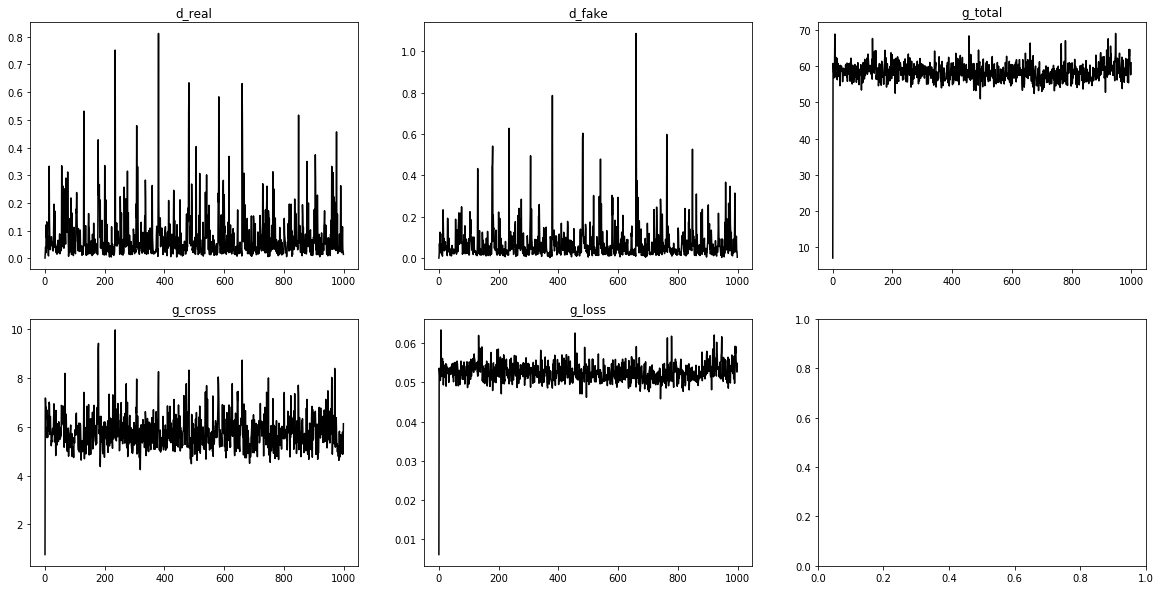

In [30]:
vec = load('monday_schedualer_18.11/loss__L1_(1,1000)w_130e3iter_8b')
plot_loss(vec)

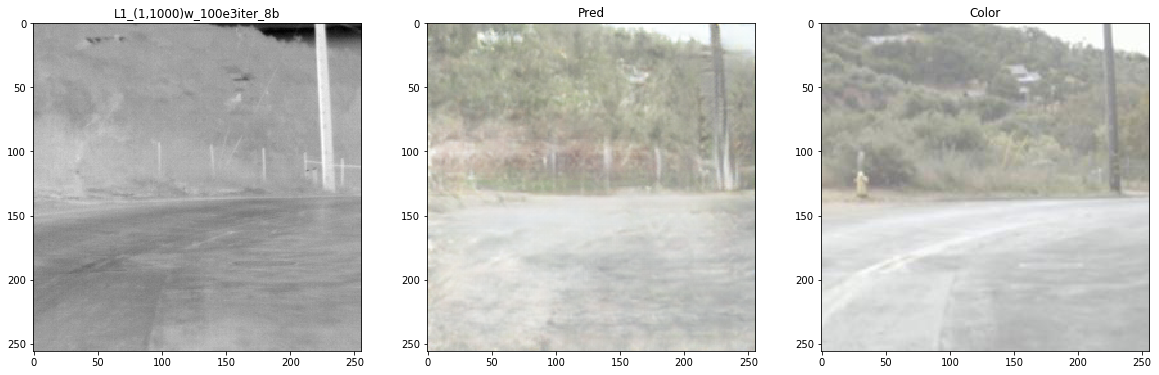

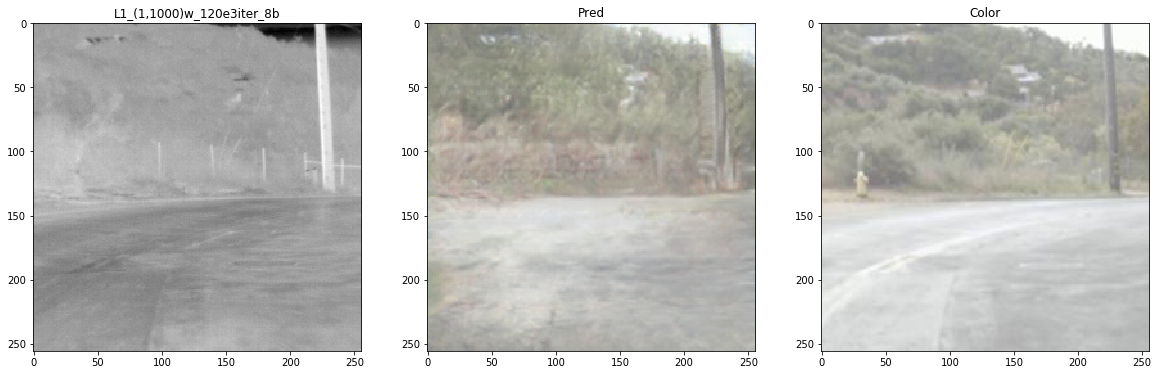

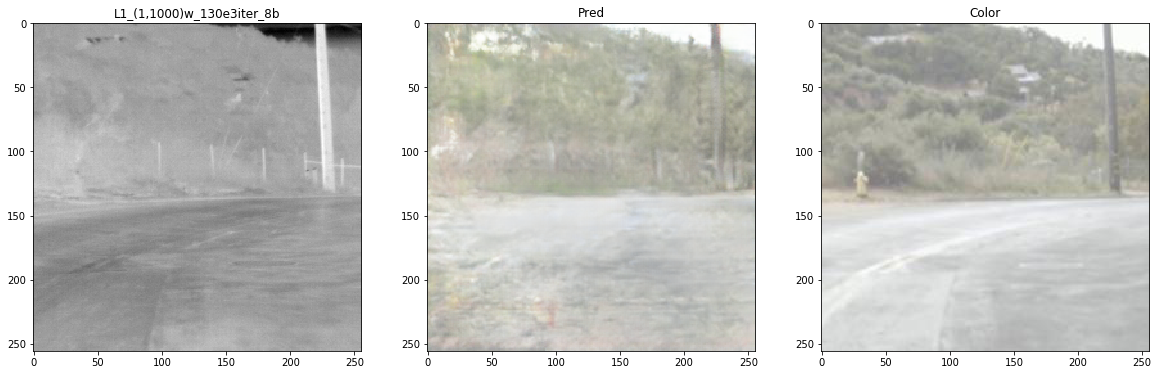

In [39]:
# batch_size = 1
# data_gen_args = dict(horizontal_flip=True)
# image_datagen = ImageDataGenerator(**data_gen_args)        
# yimage_generator = image_datagen.flow(y_train, seed=2019, batch_size=batch_size, shuffle=True)
# Ximage_generator = image_datagen.flow(X_train, seed=2019, batch_size=batch_size, shuffle=True)
# train_generator = zip(Ximage_generator, yimage_generator)
# train_crops = crop_generator(train_generator, 256, rand_crop=False)
g_names = ['L1_(1,1000)w_100e3iter_8b','L1_(1,1000)w_120e3iter_8b','L1_(1,1000)w_130e3iter_8b']
plot_compare(g_names, dir_name, g_model, train_crops)